<a href="https://colab.research.google.com/github/im-karthikrajesh/brand-analysis-using-twitter/blob/main/Brand_Analysis_using_Twitter_X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Brand Analysis using Twitter/X**

**1. Import Libraries and Download Resources**

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import re
import ast
import nltk
import random
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from tabulate import tabulate
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from scipy.stats import skew
from collections import Counter
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [ ]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Setting Seaborn style for plots
sns.set(style="whitegrid")

**2. Load Data and Display Basic Summaries**

In [ ]:
# Load the Datasets
try:
    df_adidas = pd.read_csv('/content/adidas_tweets.csv', encoding='utf-8')
    df_lululemon = pd.read_csv('/content/lululemon_tweets.csv', encoding='utf-8')
    print("Datasets loaded successfully!")
except Exception as e:
    print("Error loading CSV files:", e)

Datasets loaded successfully!


In [ ]:
# Function to display the general summary of the datasets
def dataset_summary(df, dataset_name):
    summary = [
        ["Dataset Name", dataset_name],
        ["Number of Rows", df.shape[0]],
        ["Number of Columns", df.shape[1]],
        ["Columns", ", ".join(df.columns)]
    ]
    return summary

def columns_info(df):
    info = [[col, df[col].dtype, df[col].isnull().sum()] for col in df.columns]
    return info

# Display the summary of the datasets
print("Adidas Tweets Dataset Summary:")
print(tabulate(dataset_summary(df_adidas, "Adidas Tweets"), headers=["Metric", "Value"], tablefmt="pretty"))
print("\nLululemon Tweets Dataset Summary:")
print(tabulate(dataset_summary(df_lululemon, "Lululemon Tweets"), headers=["Metric", "Value"], tablefmt="pretty"))

print("\nAdidas Tweets Dataset - Column Details:")
print(tabulate(columns_info(df_adidas), headers=["Column", "Data Type", "Missing Values"], tablefmt="pretty"))
print("\nLululemon Tweets Dataset - Column Details:")
print(tabulate(columns_info(df_lululemon), headers=["Column", "Data Type", "Missing Values"], tablefmt="pretty"))

Adidas Tweets Dataset Summary:
+-------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|      Metric       |                                                                                                              Value                                                                                                              |
+-------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   Dataset Name    |                                                                                                          Adidas Tweets                                                                                     

In [ ]:
# Dataset-level Descriptive Statistics
print("\n--- Dataset-level Descriptive Statistics ---")

summary_stats = []
for name, df in [
    ("Adidas Tweets", df_adidas),
    ("Lululemon Tweets", df_lululemon)
]:
    # Total number of tweets
    n_tweets = df.shape[0]
    # Number of unique users
    n_users = df['user.id'].nunique()
    # Date range: parse 'created_at' to datetime
    dates = pd.to_datetime(df['created_at'], errors='coerce')
    date_min = dates.min().date()
    date_max = dates.max().date()
    date_range = f"{date_min} to {date_max}"
    # Percentage of tweets with a non-empty user.location
    loc_pct = df['user.location'].notna().mean() * 100

    summary_stats.append([
        name,
        n_tweets,
        n_users,
        date_range,
        f"{loc_pct:.2f}%"
    ])

print(tabulate(
    summary_stats,
    headers=["Dataset", "Tweets", "Unique Users", "Date Range", "Location Available (%)"],
    tablefmt="pretty"
))


--- Dataset-level Descriptive Statistics ---
+------------------+--------+--------------+--------------------------+------------------------+
|     Dataset      | Tweets | Unique Users |        Date Range        | Location Available (%) |
+------------------+--------+--------------+--------------------------+------------------------+
|  Adidas Tweets   | 38212  |    29145     | 2021-10-01 to 2022-01-01 |         72.69%         |
| Lululemon Tweets |  6190  |     4463     | 2021-10-01 to 2022-01-01 |         72.33%         |
+------------------+--------+--------------+--------------------------+------------------------+


**3. Data Cleaning and Quality Check**

In [ ]:
# Data cleaning and ensuring quality
def clean_dataset(df, dataset_name):
    print(f"\n--- Cleaning {dataset_name} Dataset ---")

    # Dropping duplicates if any
    duplicate_count = df.duplicated().sum()
    print(f"Number of duplicate rows: {duplicate_count}")
    if duplicate_count > 0:
        df.drop_duplicates(inplace=True)

    # Vectorized conversion to datetime
    df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    if df['created_at'].isnull().sum() > 0:
        print("Warning: Some 'created_at' values could not be converted and are set to NaT.")
    else:
        print("'created_at' column converted to datetime successfully.")

    # Handle missing values in 'user.location'
    df['location_available'] = df['user.location'].notnull()
    df['user.location'] = df['user.location'].fillna("Not Provided")
    print("Missing values in 'user.location' have been handled (filled with 'Not Provided').")

    return df

# Clean both datasets
df_adidas_clean = clean_dataset(df_adidas, "Adidas Tweets")
df_lululemon_clean = clean_dataset(df_lululemon, "Lululemon Tweets")


--- Cleaning Adidas Tweets Dataset ---
Number of duplicate rows: 0
'created_at' column converted to datetime successfully.
Missing values in 'user.location' have been handled (filled with 'Not Provided').

--- Cleaning Lululemon Tweets Dataset ---
Number of duplicate rows: 0
'created_at' column converted to datetime successfully.
Missing values in 'user.location' have been handled (filled with 'Not Provided').


In [ ]:
# Post-Cleaning Quality Check
def post_cleaning_check(df, dataset_name):
    print(f"\n--- Post-Cleaning Quality Check for {dataset_name} ---")

    # Missing values table
    missing_values = df.isnull().sum().reset_index()
    missing_values.columns = ["Column", "Missing Values"]
    print("\nMissing values:")
    print(tabulate(missing_values, headers="keys", tablefmt="pretty"))

    # Duplicate rows count
    duplicate_count = df.duplicated().sum()
    print(f"\nDuplicate rows: {duplicate_count}")

    # Location available counts table
    if 'location_available' in df.columns:
        location_counts = df['location_available'].value_counts().reset_index()
        location_counts.columns = ["Location", "Count"]
        print("\nLocation Available counts:")
        print(tabulate(location_counts, headers="keys", tablefmt="pretty"))
    else:
        print("\nColumn 'location_available' not found in the dataset.")

    # Preview of the dataset
    preview = df.head()
    print(f"\nPreview of {dataset_name}:")
    print(tabulate(preview, headers="keys", tablefmt="pretty"))

# Example usage for the Adidas and Lululemon cleaned datasets:
post_cleaning_check(df_adidas_clean, "Adidas Tweets")
post_cleaning_check(df_lululemon_clean, "Lululemon Tweets")


--- Post-Cleaning Quality Check for Adidas Tweets ---

Missing values:
+----+----------------------+----------------+
|    |        Column        | Missing Values |
+----+----------------------+----------------+
| 0  |      created_at      |       0        |
| 1  |          id          |       0        |
| 2  |      full_text       |       0        |
| 3  |   is_quote_status    |       0        |
| 4  |    retweet_count     |       0        |
| 5  |    favorite_count    |       0        |
| 6  |       user.id        |       0        |
| 7  |      user.name       |       0        |
| 8  |   user.screen_name   |       0        |
| 9  |    user.location     |       0        |
| 10 | user.followers_count |       0        |
| 11 |  user.friends_count  |       0        |
| 12 |  user.listed_count   |       0        |
| 13 |    user.verified     |       0        |
| 14 | user.statuses_count  |       0        |
| 15 |  location_available  |       0        |
+----+----------------------+------

**4. Advanced Text Preprocessing**

In [ ]:
# Advanced Text Preprocessing

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Basic Text Cleaning Function
def basic_clean(text):
    """Removes URLs, mentions, hashtag symbols, punctuation and converts text to lowercase."""
    try:
        text = re.sub(r'http\S+', '', text)           # Remove URLs
        text = re.sub(r'@[A-Za-z0-9_]+', '', text)    # Remove Twitter/X mentions
        text = re.sub(r'#', '', text)                 # Remove hashtag symbol
        text = re.sub(r'[^A-Za-z0-9\s]', '', text)    # Remove punctuation and special characters
        return text.lower().strip()                   # Convert to lowercase and trim whitespace
    except Exception as e:
        print(f"Error in basic_clean: {e} for text: {text}")
        return ""

# Advanced Preprocessing: Tokenization, Stopword Removal, and Lemmatization
def advanced_preprocess(text):
    """
    Cleans text using basic_clean, removes emojis, tokenizes text,
    filters out stopwords and single-character tokens, applies lemmatization.
    Returns processed string.
    """
    try:
        # Basic text cleaning
        text = basic_clean(text)

        # Remove emojis using a regex pattern
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)

        # Tokenize text into words
        try:
            tokens = word_tokenize(text)
        except LookupError:
            nltk.download('punkt_tab')
            tokens = word_tokenize(text)

        # Remove single-character tokens and stopwords
        tokens = [token for token in tokens if len(token) > 1]  # Removes short tokens with length 1
        processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

        # Returns the tokens into a single string
        return " ".join(processed_tokens)
    except Exception as e:
        print(f"Error in advanced_preprocess: {e} for text: {text}")
        return ""

# Advanced Preprocessing on Cleaned DataFrames
df_adidas_clean['processed_text'] = df_adidas_clean['full_text'].apply(advanced_preprocess)
df_lululemon_clean['processed_text'] = df_lululemon_clean['full_text'].apply(advanced_preprocess)

In [ ]:
# Verify the output
print("\nSample processed texts from Adidas dataset:")
print(tabulate(df_adidas_clean[['full_text', 'processed_text']].head(), headers="keys", tablefmt="pretty"))

print("\nSample processed texts from Lululemon dataset:")
print(tabulate(df_lululemon_clean[['full_text', 'processed_text']].head(), headers="keys", tablefmt="pretty"))


Sample processed texts from Adidas dataset:
+---+----------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------+
|   |                                                                  full_text                                                                   |                               processed_text                               |
+---+----------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------+
| 0 |                                  @_christiankeith @d1vetsam @KicksFinder They are available too at @adidas                                   |                                 available                                  |
| 1 |      SELENA boosted up Puma stocks by 40%  He

**5. Hashtag and Mention Extraction, Word Clouds**


Top 10 Hashtags for Adidas:
+---+---------------------+-----------+
|   |       Hashtag       | Frequency |
+---+---------------------+-----------+
| 0 |   XboxSweepstakes   |   7041    |
| 1 | ImpossibleIsNothing |   1153    |
| 2 |       Xbox20        |    481    |
| 3 |       adidas        |    455    |
| 4 |      giveaway       |    405    |
| 5 |       running       |    403    |
| 6 |    runningshoes     |    399    |
| 7 |       Adidas        |    202    |
| 8 |       BoltUp        |    141    |
| 9 |         NFT         |    137    |
+---+---------------------+-----------+


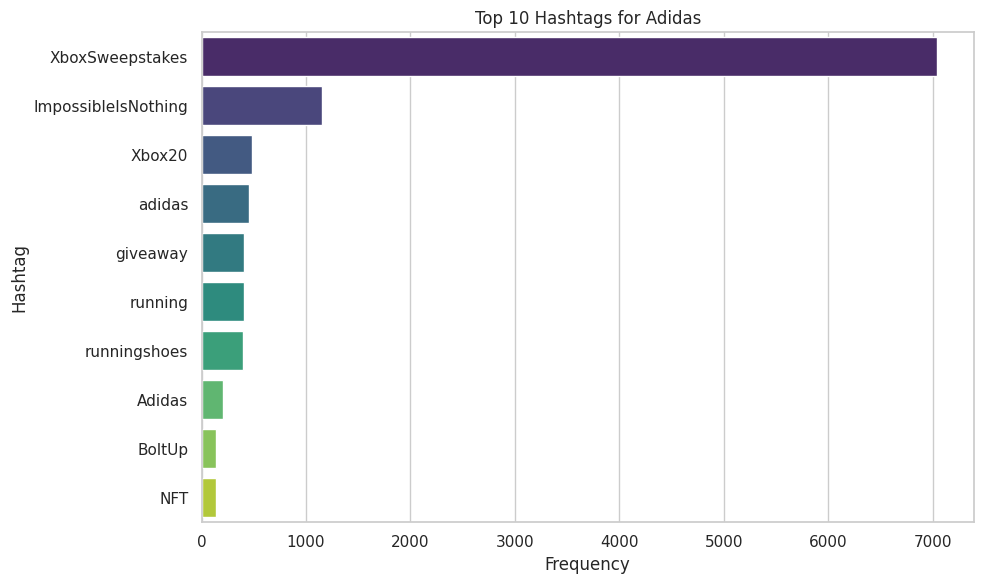


Top 10 Hashtags for Lululemon:
+---+-------------------+-----------+
|   |      Hashtag      | Frequency |
+---+-------------------+-----------+
| 0 |   thesweatlife    |    113    |
| 1 | lululemoncoalprit |    71     |
| 2 | FossilFreeFashion |    65     |
| 3 | 12DaysOfCheckout  |    62     |
| 4 |    CoalSweats     |    61     |
| 5 |     lululemon     |    56     |
| 6 |    TeamCanada     |    42     |
| 7 |       yoga        |    29     |
| 8 |      fitness      |    19     |
| 9 |    Beijing2022    |    17     |
+---+-------------------+-----------+


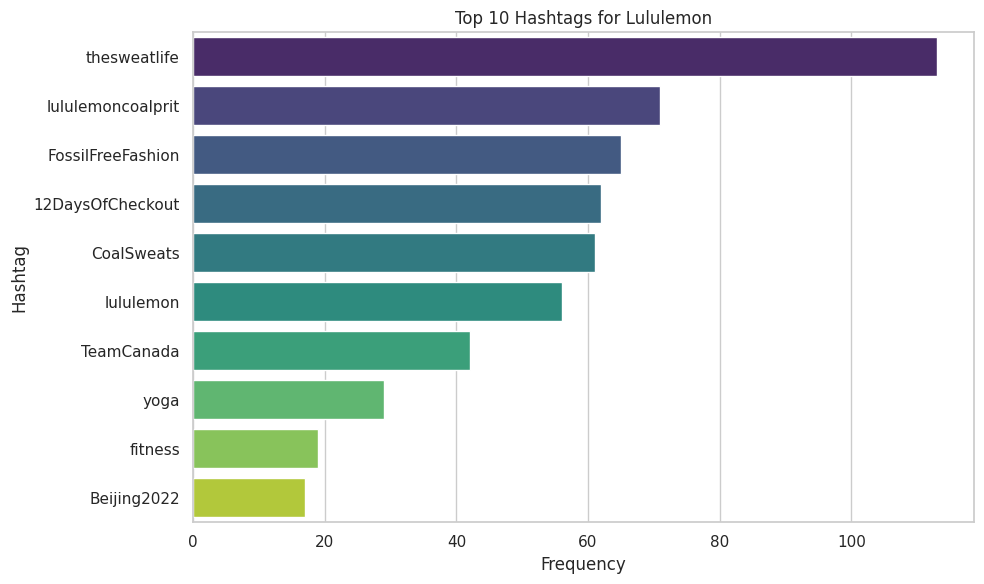


Top 10 Mentions for Adidas:
+---+-----------------+-----------+
|   |     Mention     | Frequency |
+---+-----------------+-----------+
| 0 |     adidas      |   36167   |
| 1 |      Xbox       |   8729    |
| 2 |  AustinEkeler   |   7567    |
| 3 |  adidasFballUS  |   7282    |
| 4 |      Nike       |   2661    |
| 5 | adidasoriginals |   2561    |
| 6 |    Hyperkin     |   1097    |
| 7 |   BoredApeYC    |   1003    |
| 8 |     Adidas      |    611    |
| 9 |   adidasHoops   |    493    |
+---+-----------------+-----------+


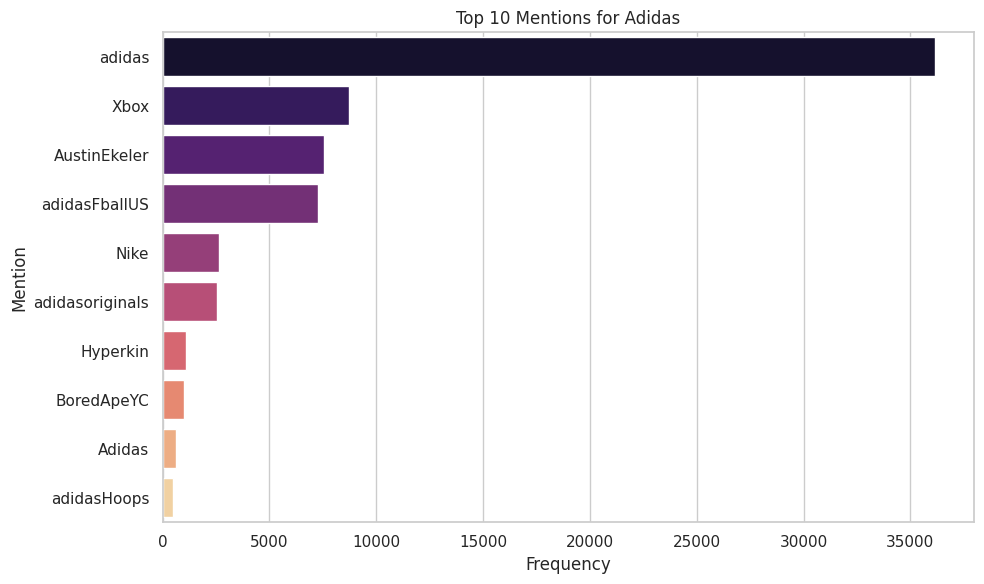


Top 10 Mentions for Lululemon:
+---+----------------+-----------+
|   |    Mention     | Frequency |
+---+----------------+-----------+
| 0 |   lululemon    |   6233    |
| 1 |   TeamCanada   |    297    |
| 2 |      fast      |    146    |
| 3 |   standearth   |    108    |
| 4 |      Nike      |    102    |
| 5 | calvinmcdonald |    93     |
| 6 |  hockeynight   |    80     |
| 7 |    DeezeFi     |    79     |
| 8 |  Devin_Heroux  |    74     |
| 9 |   Lululemon    |    63     |
+---+----------------+-----------+


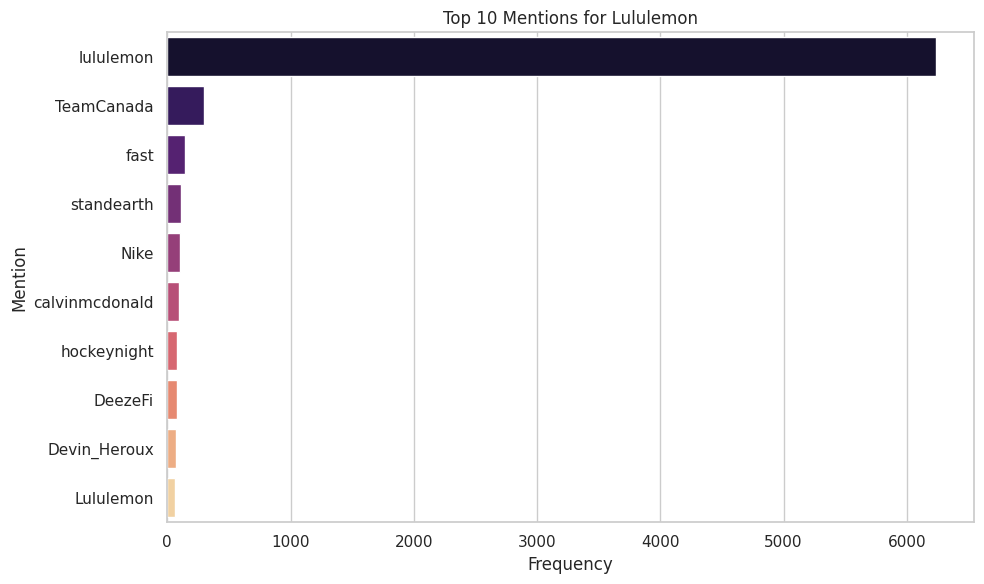

In [ ]:
# Hashtag and Mention Extraction

# Functions to Extract Hashtags and Mentions
def extract_hashtags(text):
    """Extracts hashtags from text"""
    try:
        return re.findall(r"#(\w+)", text)
    except Exception as e:
        print(f"Error in extract_hashtags: {e} for text: {text}")
        return []

def extract_mentions(text):
    """Extracts user mentions from text"""
    try:
        return re.findall(r"@(\w+)", text)
    except Exception as e:
        print(f"Error in extract_mentions: {e} for text: {text}")
        return []

# Creating new columns for hashtags and mentions using the original tweet
df_adidas_clean['hashtags'] = df_adidas_clean['full_text'].apply(lambda x: extract_hashtags(x))
df_adidas_clean['mentions'] = df_adidas_clean['full_text'].apply(lambda x: extract_mentions(x))
df_lululemon_clean['hashtags'] = df_lululemon_clean['full_text'].apply(lambda x: extract_hashtags(x))
df_lululemon_clean['mentions'] = df_lululemon_clean['full_text'].apply(lambda x: extract_mentions(x))

# Function to Plot Top Hashtags
def plot_top_hashtags(df, brand_name, top_n=10):
    """Plots a bar chart of the top N hashtags for the given dataset"""
    hashtags = df['hashtags'].sum()  # Flattens list of lists
    hashtag_counts = Counter(hashtags)
    top_hashtags = hashtag_counts.most_common(top_n)

    if top_hashtags:
        hashtags_list, counts = zip(*top_hashtags)
    else:
        hashtags_list, counts = [], []

    table_data = pd.DataFrame(top_hashtags, columns=["Hashtag", "Frequency"])
    print(f"\nTop {top_n} Hashtags for {brand_name}:")
    print(tabulate(table_data, headers="keys", tablefmt="pretty"))

    # Plotting the chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(hashtags_list), hue=list(hashtags_list),
                dodge=False, palette="viridis", legend=False)
    plt.title(f"Top {top_n} Hashtags for {brand_name}")
    plt.xlabel("Frequency")
    plt.ylabel("Hashtag")
    plt.tight_layout()
    plt.show()

# Function to Plot Top Mentions
def plot_top_mentions(df, brand_name, top_n=10):
    """Plots a bar chart of the top N mentions for the given dataset."""
    mentions = df['mentions'].sum()  # Flattens list of lists
    mention_counts = Counter(mentions)
    top_mentions = mention_counts.most_common(top_n)

    if top_mentions:
        mentions_list, counts = zip(*top_mentions)
    else:
        mentions_list, counts = [], []

    table_data = pd.DataFrame(top_mentions, columns=["Mention", "Frequency"])
    print(f"\nTop {top_n} Mentions for {brand_name}:")
    print(tabulate(table_data, headers="keys", tablefmt="pretty"))

    # Plotting the chart
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(mentions_list), hue=list(mentions_list),
                dodge=False, palette="magma", legend=False)
    plt.title(f"Top {top_n} Mentions for {brand_name}")
    plt.xlabel("Frequency")
    plt.ylabel("Mention")
    plt.tight_layout()
    plt.show()

# Top hashtags and mentions for each brand
plot_top_hashtags(df_adidas_clean, "Adidas")
plot_top_hashtags(df_lululemon_clean, "Lululemon")
plot_top_mentions(df_adidas_clean, "Adidas")
plot_top_mentions(df_lululemon_clean, "Lululemon")

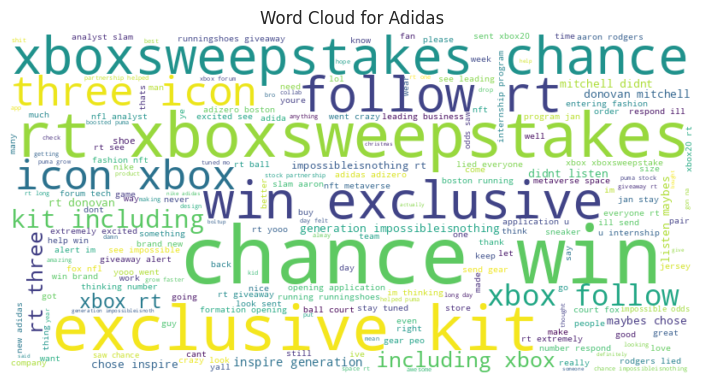

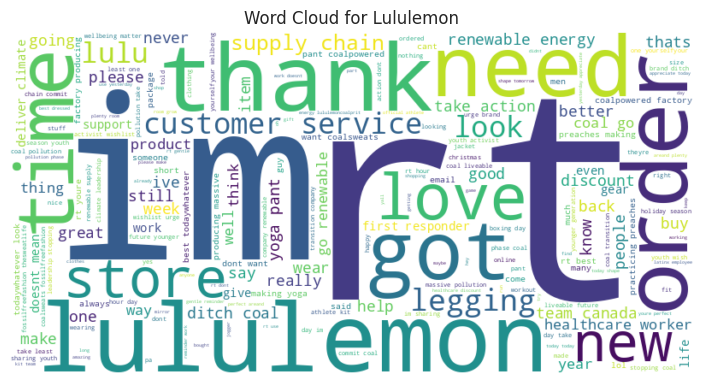

In [ ]:
# Word Cloud Visualization for Processed Text

def plot_wordcloud(df, brand_name):
    """Generates and plots a word cloud from the processed text column"""
    try:
        text = " ".join(df['processed_text'].tolist())
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        plt.figure(figsize=(8, 4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Word Cloud for {brand_name}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating word cloud for {brand_name}: {e}")

# Word clouds for each brand
plot_wordcloud(df_adidas_clean, "Adidas")
plot_wordcloud(df_lululemon_clean, "Lululemon")

**6. Exploratory Data Analysis (EDA) and Time Series Analysis**

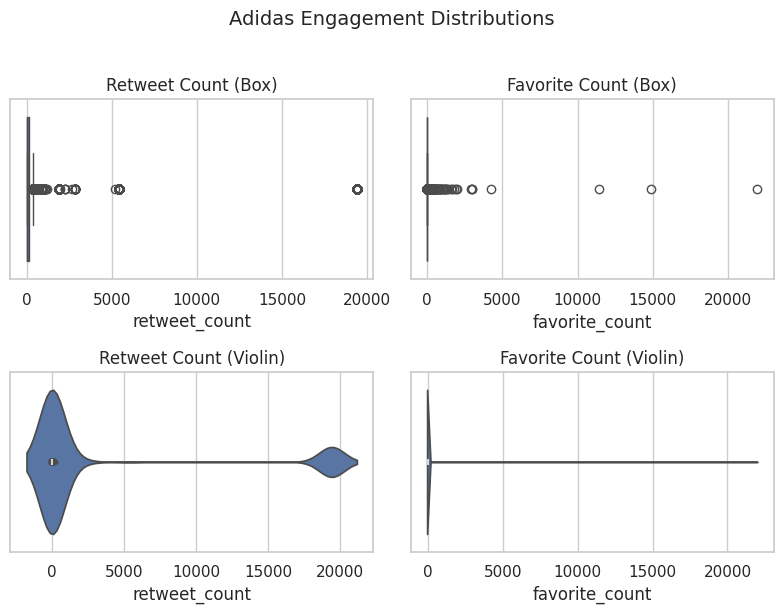

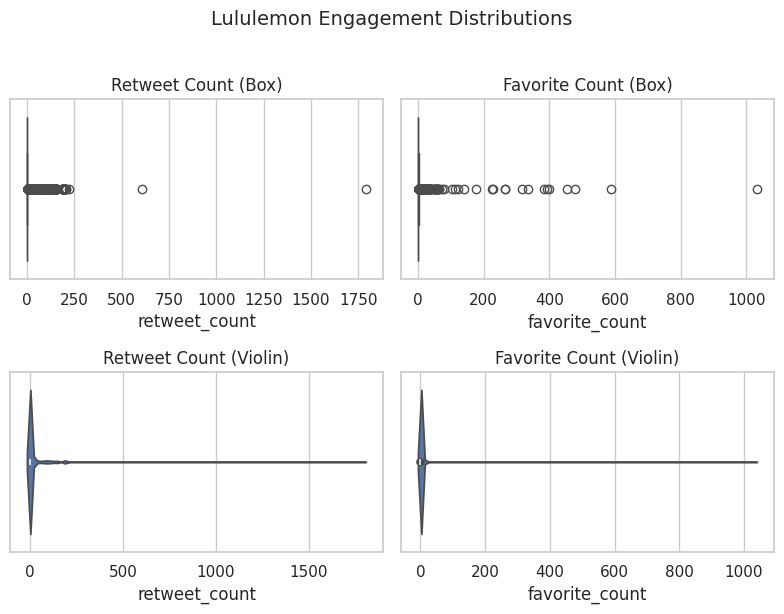

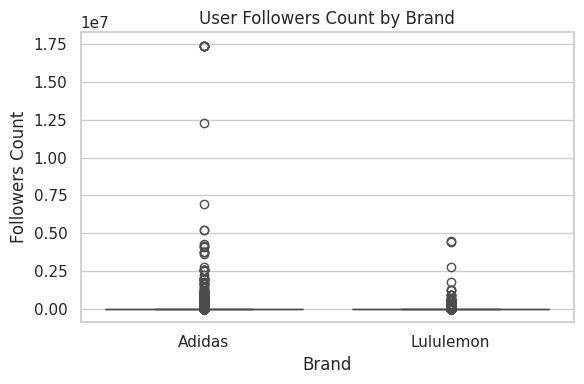

In [ ]:
def plot_engagement_distributions(df, brand_name):
    """
    Plot a 2×2 grid of box & violin plots for retweet_count and favorite_count.
    """
    fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=False)
    fig.suptitle(f"{brand_name} Engagement Distributions", y=1.02, fontsize=14)

    # Retweet Count (Box)
    sns.boxplot(x='retweet_count', data=df, ax=axes[0, 0])
    axes[0, 0].set_title("Retweet Count (Box)")

    # Retweet Count (Violin)
    sns.violinplot(x='retweet_count', data=df, ax=axes[1, 0])
    axes[1, 0].set_title("Retweet Count (Violin)")

    # Favorite Count (Box)
    sns.boxplot(x='favorite_count', data=df, ax=axes[0, 1])
    axes[0, 1].set_title("Favorite Count (Box)")

    # Favorite Count (Violin)
    sns.violinplot(x='favorite_count', data=df, ax=axes[1, 1])
    axes[1, 1].set_title("Favorite Count (Violin)")

    plt.tight_layout()
    plt.show()

# Plot for Adidas
plot_engagement_distributions(df_adidas_clean, "Adidas")

# Plot for Lululemon
plot_engagement_distributions(df_lululemon_clean, "Lululemon")


# User Followers Count Comparison

# Combine both brands into one DataFrame for easy comparison
combined_df = pd.concat([
    df_adidas_clean.assign(brand='Adidas'),
    df_lululemon_clean.assign(brand='Lululemon')
], ignore_index=True)

plt.figure(figsize=(6, 4))
# Box plot of user.followers_count by brand
sns.boxplot(x='brand', y='user.followers_count', data=combined_df)
plt.title("User Followers Count by Brand")
plt.xlabel("Brand")
plt.ylabel("Followers Count")
plt.tight_layout()
plt.show()

In [ ]:
# Time Series Analysis

def compute_time_series_metrics(df: pd.DataFrame) -> pd.DataFrame:

    # Check 'created_at' is in datetime format
    if df['created_at'].dtype != 'datetime64[ns, UTC]':
        print("created_at column is not datetime. Converting now...")
        df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

    # Extract date (day-level)
    df['date'] = df['created_at'].dt.date

    # Daily aggregation: count tweets and average engagement metrics
    daily = df.groupby('date').agg({
        'retweet_count': 'mean',
        'favorite_count': 'mean',
        'id': 'count'
    }).rename(columns={'id': 'tweet_count'}).reset_index()

    # Compute 7-day rolling averages for tweet count and retweet average
    daily['tweet_count_rolling'] = daily['tweet_count'].rolling(window=7, min_periods=1).mean()
    daily['retweet_count_rolling'] = daily['retweet_count'].rolling(window=7, min_periods=1).mean()
    return daily

# Compute daily aggregates for Adidas and Lululemon
adidas_daily = compute_time_series_metrics(df_adidas_clean)
lululemon_daily = compute_time_series_metrics(df_lululemon_clean)

# Compute weekly aggregates by resampling using week start - Monday
def compute_weekly_metrics(daily_df: pd.DataFrame) -> pd.DataFrame:

    # Convert 'date' to datetime to allow resampling
    daily_df['date'] = pd.to_datetime(daily_df['date'])
    weekly = daily_df.resample('W-MON', on='date').agg({
        'tweet_count': 'sum',
        'retweet_count': 'mean'
    }).reset_index().sort_values('date')
    weekly.rename(columns={'date': 'week_start'}, inplace=True)
    return weekly

adidas_weekly = compute_weekly_metrics(adidas_daily)
lululemon_weekly = compute_weekly_metrics(lululemon_daily)

In [ ]:
# Time Series Visualizations
print("Generating interactive time series plots")

fig_adidas = px.line(adidas_daily, x='date', y=['tweet_count', 'tweet_count_rolling'],
                     title="Adidas: Daily Tweet Count & 7-Day Rolling Average",
                     labels={"value": "Tweet Count", "variable": "Metric"})
fig_adidas.show()

fig_lululemon = px.line(lululemon_daily, x='date', y=['tweet_count', 'tweet_count_rolling'],
                        title="Lululemon: Daily Tweet Count & 7-Day Rolling Average",
                        labels={"value": "Tweet Count", "variable": "Metric"})
fig_lululemon.show()

# Interactive weekly aggregated plot
print("Generating weekly aggregated interactive plots")
fig_adidas_weekly = px.line(adidas_weekly, x='week_start', y='tweet_count',
                            title="Adidas: Weekly Tweet Count",
                            labels={"week_start": "Week Start", "tweet_count": "Weekly Tweet Count"})
fig_adidas_weekly.show()

fig_lululemon_weekly = px.line(lululemon_weekly, x='week_start', y='tweet_count',
                               title="Lululemon: Weekly Tweet Count",
                               labels={"week_start": "Week Start", "tweet_count": "Weekly Tweet Count"})
fig_lululemon_weekly.show()

Generating interactive time series plots


Generating weekly aggregated interactive plots


**7. Sentiment Analysis and Topic Modeling**

In [ ]:
# Sentiment and Text Analysis

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

def compute_vader_sentiment(text: str) -> float:
    """Computes and returns the VADER compound sentiment score for the given text"""
    try:
        score = sid.polarity_scores(text)['compound']
        return score
    except Exception as e:
        print(f"Error computing VADER sentiment for text: {text}\nError: {e}")
        return 0.0

def compute_textblob_sentiment(text: str) -> tuple:
    """Computes and returns the TextBlob sentiment for the given text"""
    try:
        sentiment = TextBlob(text).sentiment  # Returns namedtuple with polarity and subjectivity
        return sentiment.polarity, sentiment.subjectivity
    except Exception as e:
        print(f"Error computing TextBlob sentiment for text: {text}\nError: {e}")
        return 0.0, 0.0

print("Calculating sentiment scores using VADER and TextBlob")

# Apply sentiment analysis on the original full_text
# For Adidas tweets:
df_adidas_clean['vader_sentiment'] = df_adidas_clean['full_text'].apply(compute_vader_sentiment)
df_adidas_clean[['textblob_polarity', 'textblob_subjectivity']] = df_adidas_clean['full_text'].apply(
    lambda text: pd.Series(compute_textblob_sentiment(text))
)

# For Lululemon tweets:
df_lululemon_clean['vader_sentiment'] = df_lululemon_clean['full_text'].apply(compute_vader_sentiment)
df_lululemon_clean[['textblob_polarity', 'textblob_subjectivity']] = df_lululemon_clean['full_text'].apply(
    lambda text: pd.Series(compute_textblob_sentiment(text))
)

# Summary statistics

# Adidas VADER Sentiment Statistics
print("\nAdidas VADER Sentiment Statistics:")
adidas_vader_stats = df_adidas_clean['vader_sentiment'].describe().to_frame().reset_index()
adidas_vader_stats.columns = ["Metric", "Value"]
print(tabulate(adidas_vader_stats, headers="keys", tablefmt="pretty"))

# Adidas TextBlob Polarity Statistics
print("\nAdidas TextBlob Polarity Statistics:")
adidas_textblob_stats = df_adidas_clean['textblob_polarity'].describe().to_frame().reset_index()
adidas_textblob_stats.columns = ["Metric", "Value"]
print(tabulate(adidas_textblob_stats, headers="keys", tablefmt="pretty"))

# Lululemon VADER Sentiment Statistics
print("\nLululemon VADER Sentiment Statistics:")
lululemon_vader_stats = df_lululemon_clean['vader_sentiment'].describe().to_frame().reset_index()
lululemon_vader_stats.columns = ["Metric", "Value"]
print(tabulate(lululemon_vader_stats, headers="keys", tablefmt="pretty"))

# Lululemon TextBlob Polarity Statistics
print("\nLululemon TextBlob Polarity Statistics:")
lululemon_textblob_stats = df_lululemon_clean['textblob_polarity'].describe().to_frame().reset_index()
lululemon_textblob_stats.columns = ["Metric", "Value"]
print(tabulate(lululemon_textblob_stats, headers="keys", tablefmt="pretty"))


Calculating sentiment scores using VADER and TextBlob

Adidas VADER Sentiment Statistics:
+---+--------+---------------------+
|   | Metric |        Value        |
+---+--------+---------------------+
| 0 | count  |       38212.0       |
| 1 |  mean  | 0.23523890924316967 |
| 2 |  std   | 0.40993779309315387 |
| 3 |  min   |       -0.9855       |
| 4 |  25%   |         0.0         |
| 5 |  50%   |         0.0         |
| 6 |  75%   |       0.6705        |
| 7 |  max   |       0.9924        |
+---+--------+---------------------+

Adidas TextBlob Polarity Statistics:
+---+--------+---------------------+
|   | Metric |        Value        |
+---+--------+---------------------+
| 0 | count  |       38212.0       |
| 1 |  mean  | 0.19228121024597172 |
| 2 |  std   | 0.3702954286605729  |
| 3 |  min   |        -1.0         |
| 4 |  25%   |         0.0         |
| 5 |  50%   |         0.0         |
| 6 |  75%   | 0.4666666666666666  |
| 7 |  max   |         1.0         |
+---+--------+-------

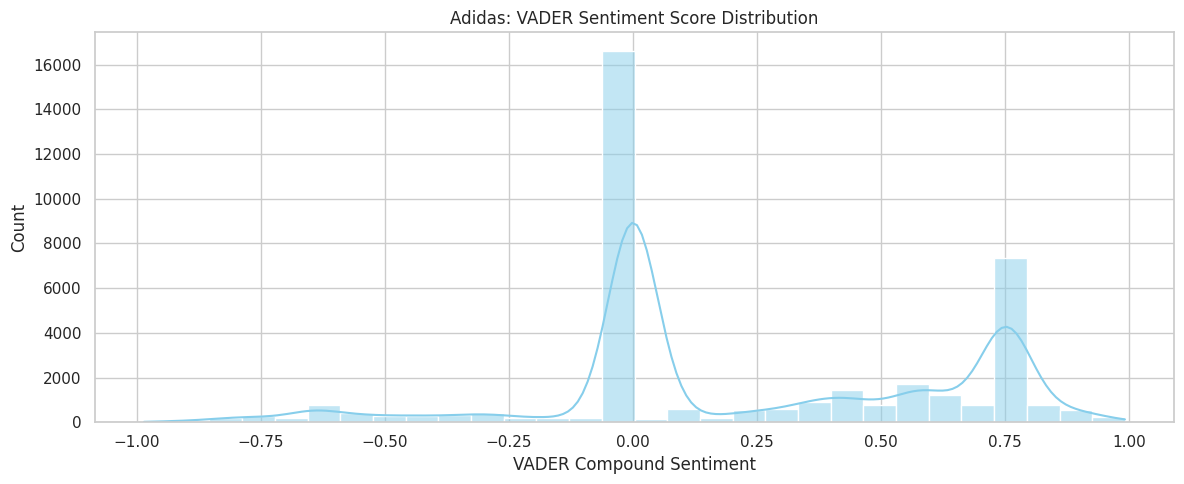

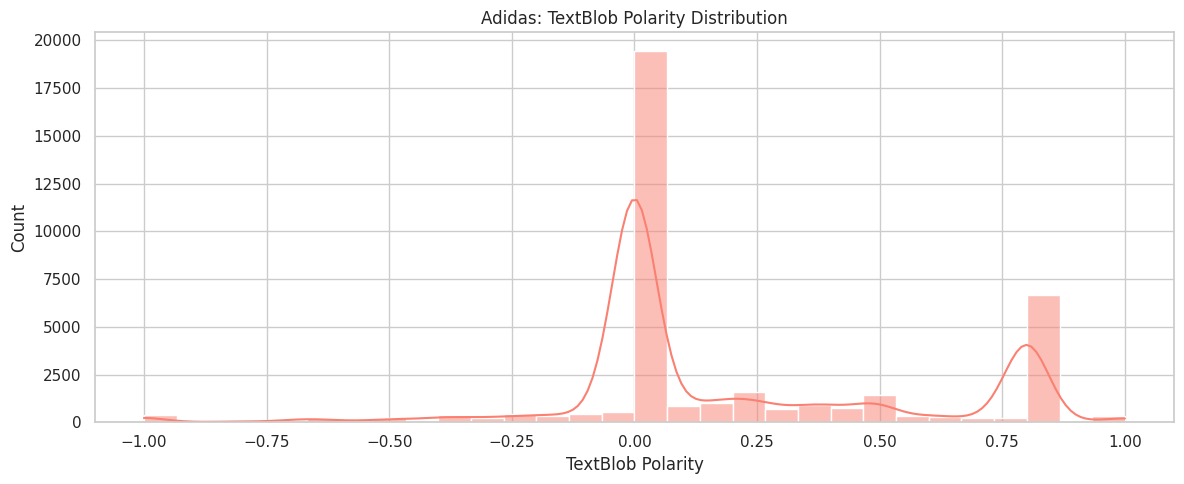

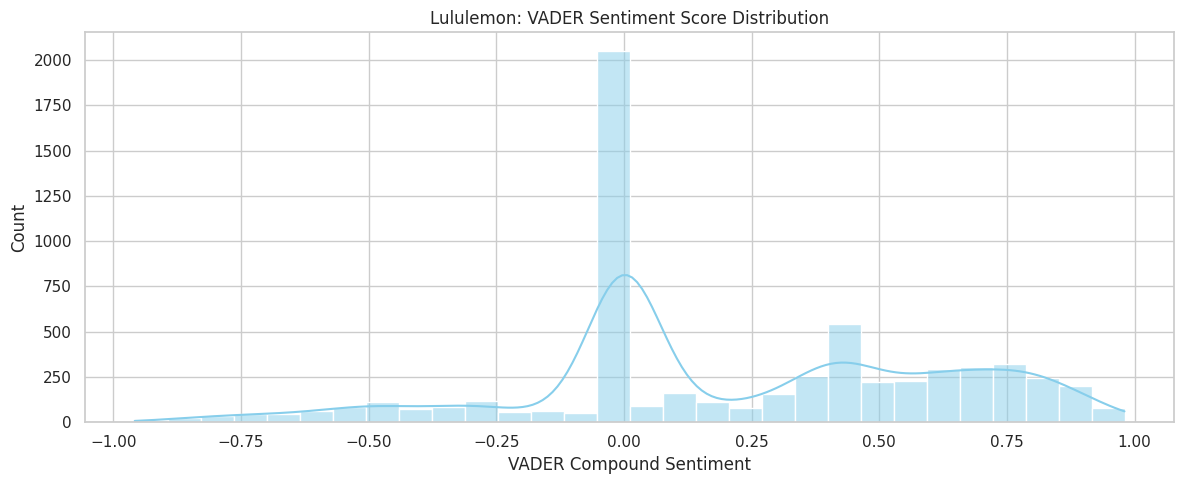

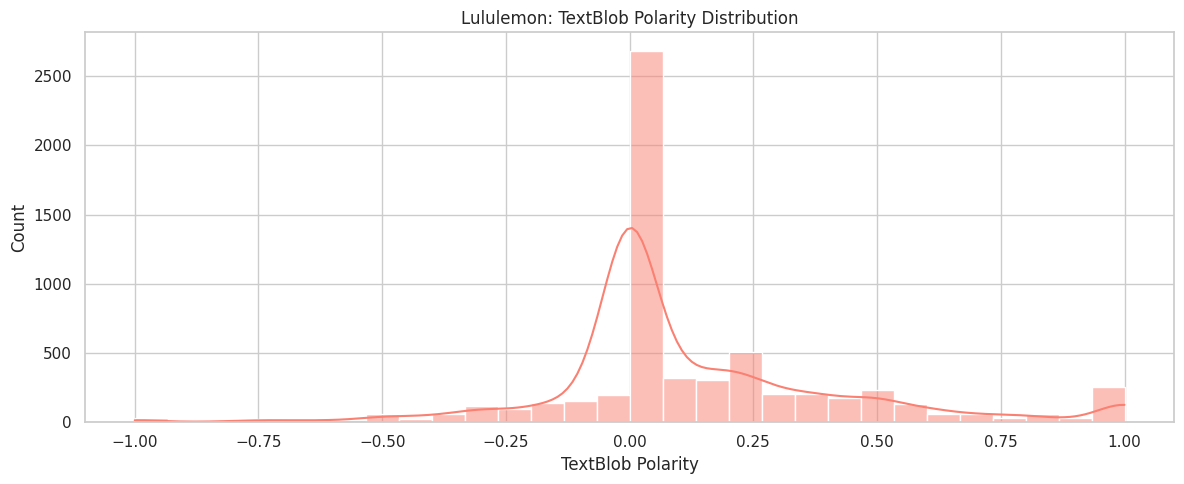

In [ ]:
# Plot histograms for the sentiment scores
plt.figure(figsize=(12, 5))
sns.histplot(df_adidas_clean['vader_sentiment'], bins=30, kde=True, color='skyblue')
plt.title("Adidas: VADER Sentiment Score Distribution")
plt.xlabel("VADER Compound Sentiment")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df_adidas_clean['textblob_polarity'], bins=30, kde=True, color='salmon')
plt.title("Adidas: TextBlob Polarity Distribution")
plt.xlabel("TextBlob Polarity")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df_lululemon_clean['vader_sentiment'], bins=30, kde=True, color='skyblue')
plt.title("Lululemon: VADER Sentiment Score Distribution")
plt.xlabel("VADER Compound Sentiment")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df_lululemon_clean['textblob_polarity'], bins=30, kde=True, color='salmon')
plt.title("Lululemon: TextBlob Polarity Distribution")
plt.xlabel("TextBlob Polarity")
plt.tight_layout()
plt.show()

In [ ]:
# Topic Modeling

# Set parameters for topic modeling
n_topics = 5       # Number of topics to extract
n_top_words = 10   # Number of top words to display for each topic

def get_topics_table(model, feature_names, n_top_words: int) -> list:
    """
    Extracts topics from an NMF model and returns them as a table (list of lists)
    where each row contains: [Topic Number, Top Words].
    """
    topics_table = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        topics_table.append([f"Topic {topic_idx + 1}", ", ".join(top_words)])
    return topics_table


# Topic Modeling for Adidas Tweets
print("\n--- Topic Modeling for Adidas Tweets ---")

# Create a TF-IDF vectorizer and transform the processed text of Adidas tweets
tfidf_vectorizer_adidas = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_adidas = tfidf_vectorizer_adidas.fit_transform(df_adidas_clean['processed_text'])

# Initialize and fit the NMF model with increased max_iter to help convergence
nmf_model_adidas = NMF(n_components=n_topics, random_state=42, max_iter=500)
nmf_features_adidas = nmf_model_adidas.fit_transform(tfidf_adidas)

# Get the feature names for interpretation
feature_names_adidas = tfidf_vectorizer_adidas.get_feature_names_out()

# Topics table for Adidas
adidas_topics_table = get_topics_table(nmf_model_adidas, feature_names_adidas, n_top_words)
print("Topics extracted using NMF on Adidas processed tweets:")
print(tabulate(adidas_topics_table, headers=["Topic", "Top Words"], tablefmt="pretty"))


# Topic Modeling for Lululemon Tweets
print("\n--- Topic Modeling for Lululemon Tweets ---")

# Create a TF-IDF vectorizer and transform the processed text of Lululemon tweets
tfidf_vectorizer_lululemon = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_lululemon = tfidf_vectorizer_lululemon.fit_transform(df_lululemon_clean['processed_text'])

# Initialize and fit the NMF model with increased max_iter
nmf_model_lululemon = NMF(n_components=n_topics, random_state=42, max_iter=500)
nmf_features_lululemon = nmf_model_lululemon.fit_transform(tfidf_lululemon)

# Get the feature names for Lululemon tweets
feature_names_lululemon = tfidf_vectorizer_lululemon.get_feature_names_out()

# Topics table for Lululemon
lululemon_topics_table = get_topics_table(nmf_model_lululemon, feature_names_lululemon, n_top_words)
print("Topics extracted using NMF on Lululemon processed tweets:")
print(tabulate(lululemon_topics_table, headers=["Topic", "Top Words"], tablefmt="pretty"))


--- Topic Modeling for Adidas Tweets ---
Topics extracted using NMF on Adidas processed tweets:
+---------+-----------------------------------------------------------------------------------------------+
|  Topic  |                                           Top Words                                           |
+---------+-----------------------------------------------------------------------------------------------+
| Topic 1 |            xbox, rt, including, icon, exclusive, follow, kit, chance, win, xbox20             |
| Topic 2 | maybes, generation, inspire, mitchell, chose, listen, donovan, impossibleisnothing, didnt, rt |
| Topic 3 |                 30, boltup, number, jersey, im, going, got, course, easy, ta                  |
| Topic 4 |      xboxsweepstakes, xbox, icon, win, love, exclusive, awesome, including, kit, chance       |
| Topic 5 |        giveaway, 10, adidas, runningshoes, boston, adizero, running, new, brand, help         |
+---------+----------------------------

**8. Perceptual Mapping and User-Level Analysis**

Starting Perceptual Mapping and User-Level Analysis

Adidas Engagement Ratio Statistics:
+---+--------+-----------------------+
|   | Metric |         Value         |
+---+--------+-----------------------+
| 0 | count  |        38037.0        |
| 1 |  mean  |  184.64263789938965   |
| 2 |  std   |   1186.850497754335   |
| 3 |  min   |          0.0          |
| 4 |  25%   |          0.0          |
| 5 |  50%   | 0.0010822510822510823 |
| 6 |  75%   |  0.3247863247863248   |
| 7 |  max   |        19396.0        |
+---+--------+-----------------------+

Adidas Engagement Ratio Values (first 10):
+---+------------------------+
|   |    engagement_ratio    |
+---+------------------------+
| 0 |          0.0           |
| 1 |          0.0           |
| 2 | 3.8010288117983936e-05 |
| 3 |          0.0           |
| 4 |          0.0           |
| 5 |          0.1           |
| 6 |          0.0           |
| 7 |          0.0           |
| 8 |          0.0           |
| 9 |  0.005387418792584376

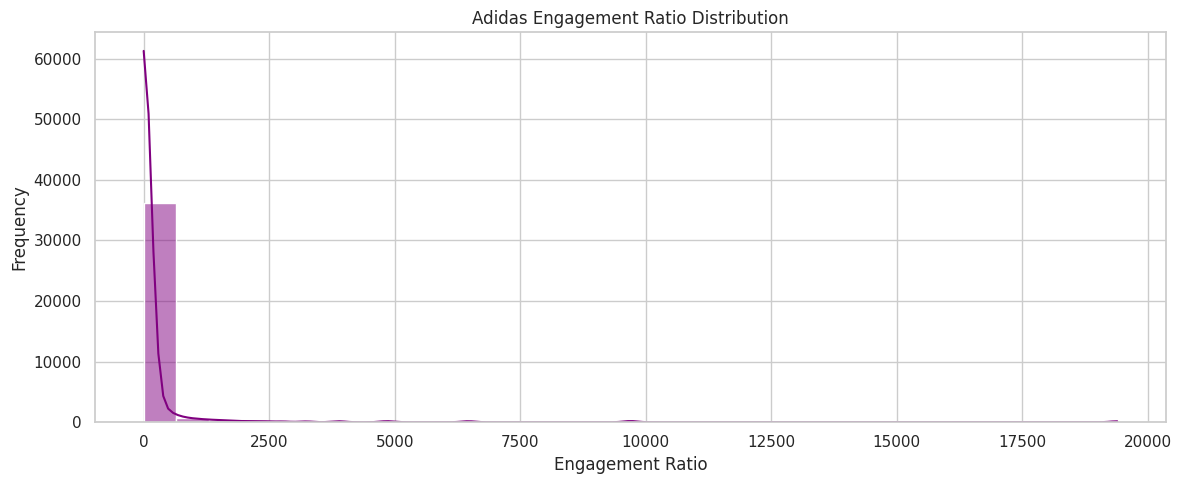

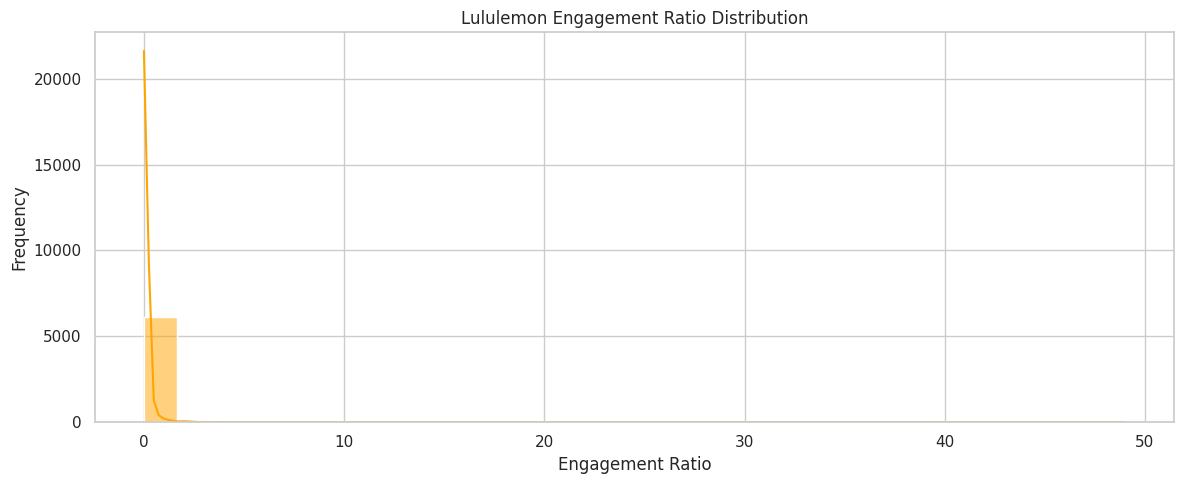

In [ ]:
# Perceptual Mapping and User-Level Analysis

print("Starting Perceptual Mapping and User-Level Analysis")

# Engagement Ratio Metrics
# engagement ratio = (retweet_count + favorite_count) / user.followers_count
# To avoid division by zero errors, replace any zero follower count with NaN
df_adidas_clean['engagement_ratio'] = (df_adidas_clean['retweet_count'] + df_adidas_clean['favorite_count']) / df_adidas_clean['user.followers_count'].replace(0, np.nan)
df_lululemon_clean['engagement_ratio'] = (df_lululemon_clean['retweet_count'] + df_lululemon_clean['favorite_count']) / df_lululemon_clean['user.followers_count'].replace(0, np.nan)


# Adidas Engagement Ratio Metrics

print("\nAdidas Engagement Ratio Statistics:")

# Descriptive statistics
adidas_desc = df_adidas_clean['engagement_ratio'].describe().to_frame().reset_index()
adidas_desc.columns = ["Metric", "Value"]
print(tabulate(adidas_desc, headers="keys", tablefmt="pretty"))

# First 10 engagement ratio values for verification
print("\nAdidas Engagement Ratio Values (first 10):")
print(tabulate(df_adidas_clean[['engagement_ratio']].head(10), headers="keys", tablefmt="pretty"))


# Lululemon Engagement Ratio Metrics

print("\nLululemon Engagement Ratio Statistics:")

lululemon_desc = df_lululemon_clean['engagement_ratio'].describe().to_frame().reset_index()
lululemon_desc.columns = ["Metric", "Value"]
print(tabulate(lululemon_desc, headers="keys", tablefmt="pretty"))

print("\nLululemon Engagement Ratio Values (first 10):")
print(tabulate(df_lululemon_clean[['engagement_ratio']].head(10), headers="keys", tablefmt="pretty"))

# Plot histograms for the engagement ratios
plt.figure(figsize=(12, 5))
sns.histplot(df_adidas_clean['engagement_ratio'].dropna(), bins=30, kde=True, color='purple')
plt.title("Adidas Engagement Ratio Distribution")
plt.xlabel("Engagement Ratio")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df_lululemon_clean['engagement_ratio'].dropna(), bins=30, kde=True, color='orange')
plt.title("Lululemon Engagement Ratio Distribution")
plt.xlabel("Engagement Ratio")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Adidas User Metrics Summary:
+---+----------------------+---------+--------------------+-------------------+-----+--------+--------+----------+------------+
|   |        Metric        |  count  |        mean        |        std        | min |  25%   |  50%   |   75%    |    max     |
+---+----------------------+---------+--------------------+-------------------+-----+--------+--------+----------+------------+
| 0 | user.followers_count | 38212.0 | 11161.73183816602  | 251255.7635378329 | 0.0 |  83.0  | 306.0  |  1008.0  | 17391710.0 |
| 1 | user.statuses_count  | 38212.0 | 28646.953600963046 | 80329.86653969578 | 1.0 | 1417.0 | 6152.5 | 23194.25 | 2449834.0  |
+---+----------------------+---------+--------------------+-------------------+-----+--------+--------+----------+------------+

Lululemon User Metrics Summary:
+---+----------------------+--------+-------------------+--------------------+-----+---------+--------+---------+-----------+
|   |        Metric        | count  |      

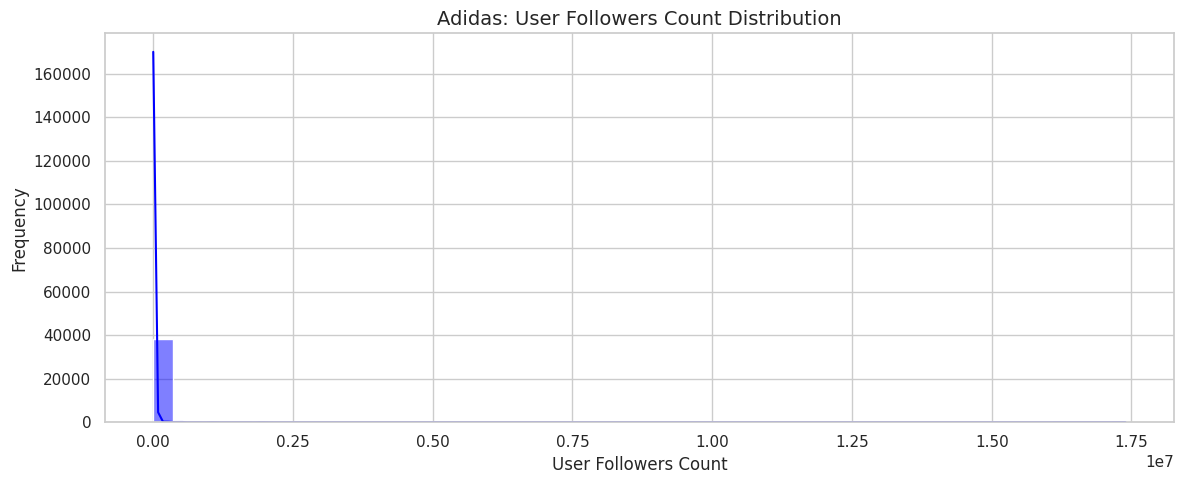

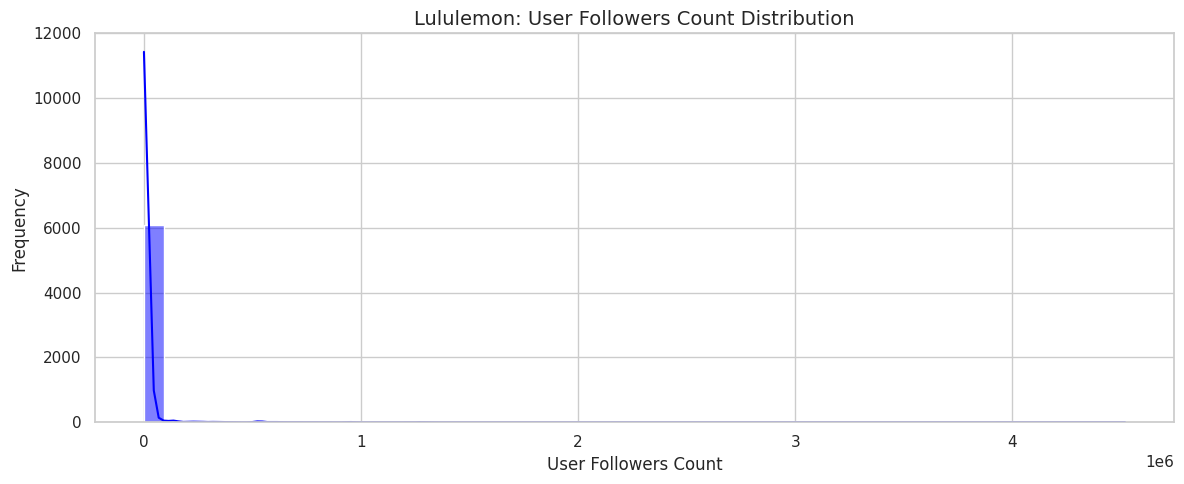

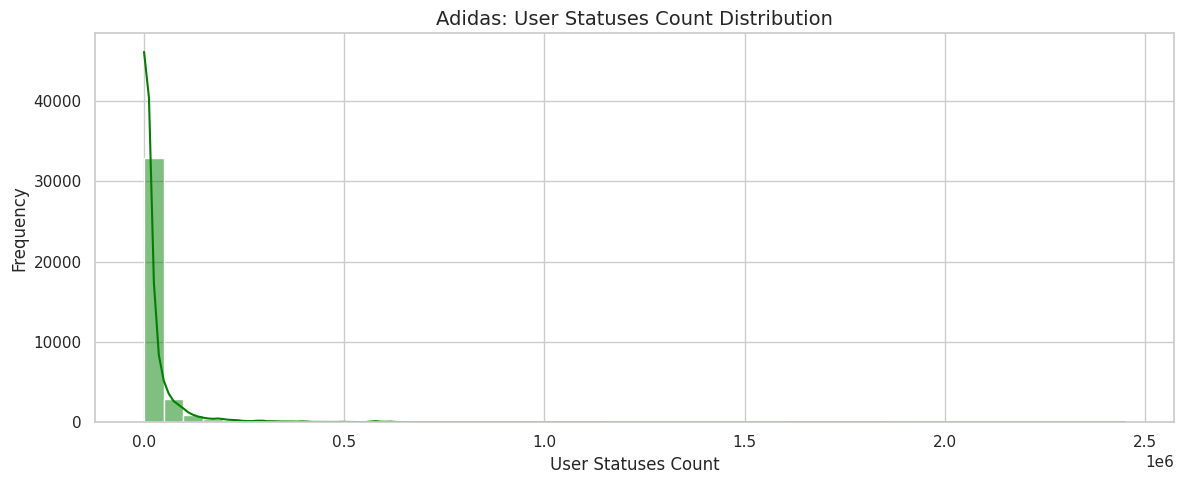

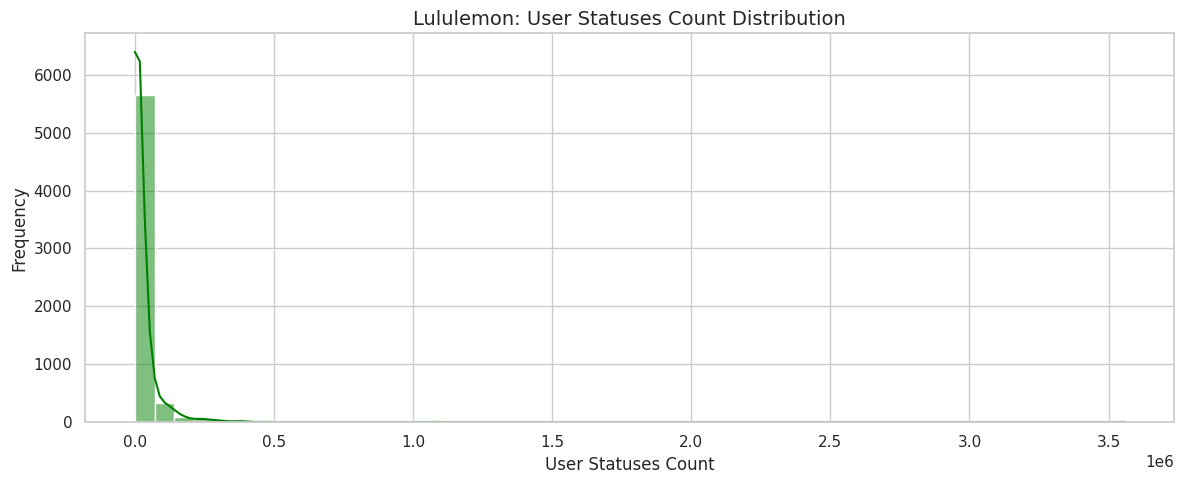

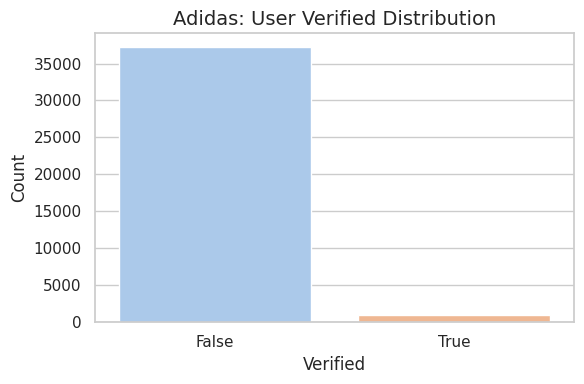

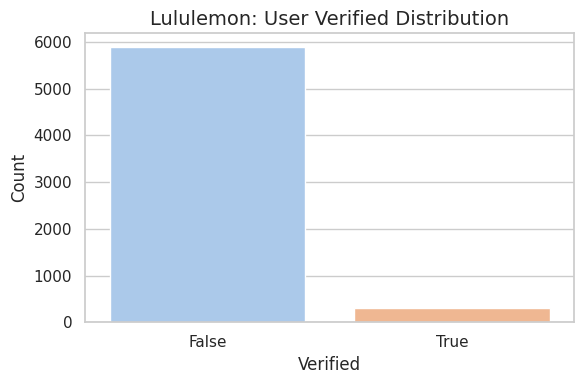

In [ ]:
# User Demographics and Distribution

# Analyze key user metrics: followers count, statuses count, and verified status.
# Creating summary tables for these metrics.

# For Adidas
adidas_user_metrics = df_adidas_clean[['user.followers_count', 'user.statuses_count']]
adidas_user_summary = adidas_user_metrics.describe().T.reset_index()
adidas_user_summary.rename(columns={"index": "Metric"}, inplace=True)
print("\nAdidas User Metrics Summary:")
print(tabulate(adidas_user_summary, headers="keys", tablefmt="pretty"))

# For Lululemon
lululemon_user_metrics = df_lululemon_clean[['user.followers_count', 'user.statuses_count']]
lululemon_user_summary = lululemon_user_metrics.describe().T.reset_index()
lululemon_user_summary.rename(columns={"index": "Metric"}, inplace=True)
print("\nLululemon User Metrics Summary:")
print(tabulate(lululemon_user_summary, headers="keys", tablefmt="pretty"))

# Plot histograms for user.followers_count
plt.figure(figsize=(12, 5))
sns.histplot(df_adidas_clean['user.followers_count'], bins=50, kde=True, color='blue')
plt.title("Adidas: User Followers Count Distribution", fontsize=14)
plt.xlabel("User Followers Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df_lululemon_clean['user.followers_count'], bins=50, kde=True, color='blue')
plt.title("Lululemon: User Followers Count Distribution", fontsize=14)
plt.xlabel("User Followers Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# Plot histograms for user.statuses_count
plt.figure(figsize=(12, 5))
sns.histplot(df_adidas_clean['user.statuses_count'], bins=50, kde=True, color='green')
plt.title("Adidas: User Statuses Count Distribution", fontsize=14)
plt.xlabel("User Statuses Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df_lululemon_clean['user.statuses_count'], bins=50, kde=True, color='green')
plt.title("Lululemon: User Statuses Count Distribution", fontsize=14)
plt.xlabel("User Statuses Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# Plot count plots for user.verified (Bar charts for verification status)
plt.figure(figsize=(6, 4))
sns.countplot(x="user.verified", data=df_adidas_clean, hue="user.verified", palette="pastel", dodge=False)
plt.title("Adidas: User Verified Distribution", fontsize=14)
plt.xlabel("Verified", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x="user.verified", data=df_lululemon_clean, hue="user.verified", palette="pastel", dodge=False)
plt.title("Lululemon: User Verified Distribution", fontsize=14)
plt.xlabel("Verified", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend([], [], frameon=False)
plt.tight_layout()
plt.show()

In [ ]:
# Perceptual Map with Integrated Sentiment, Engagement & Topic Data

print("Integrating sentiment, engagement, and topic distributions into a perceptual map")

# Recomputing Dominant Topic as Discrete Labels for Each Tweet
# 'nmf_features_adidas' and 'nmf_features_lululemon' are defined in the Topic Modeling Section

# For Adidas tweets: compute dominant topic and convert to string label 'Topic X'
dominant_topic_adidas = np.argmax(nmf_features_adidas, axis=1)
# Add 1 so topics are 1-based indexing, then convert to string
df_adidas_clean['dominant_topic'] = ("Topic " + (dominant_topic_adidas + 1).astype(str))

# For Lululemon tweets:
dominant_topic_lululemon = np.argmax(nmf_features_lululemon, axis=1)
df_lululemon_clean['dominant_topic'] = ("Topic " + (dominant_topic_lululemon + 1).astype(str))

# Add a 'brand' column for each DataFrame
df_adidas_clean['brand'] = 'Adidas'
df_lululemon_clean['brand'] = 'Lululemon'

# Combine the datasets
combined_df = pd.concat([df_adidas_clean, df_lululemon_clean], ignore_index=True)

# Subsamples if the data is too dense
sample_fraction = 0.25  # for example 25%
combined_sample = combined_df.sample(frac=sample_fraction, random_state=42)
print(f"Sampled {len(combined_sample)} rows out of {len(combined_df)} total for plotting.\n")

# Scatter plot
# x-axis: VADER sentiment
# y-axis: Engagement Ratio (log-scaled)
# Color: Dominant Topic
# Symbol: Brand
fig = px.scatter(
    combined_sample,
    x='vader_sentiment',
    y='engagement_ratio',
    color='dominant_topic',      # Discrete string labels: Topic 1, Topic 2, etc.
    symbol='brand',              # Brand symbols for clarity
    hover_data=['user.followers_count', 'user.statuses_count'],
    title="Perceptual Map: Sentiment vs. Engagement Ratio with Topic Labels",
    labels={
        "vader_sentiment": "VADER Sentiment",
        "engagement_ratio": "Engagement Ratio",
        "dominant_topic": "Dominant Topic",
        "brand": "Brand"
    },
    log_y=True  # Use logarithmic scale for engagement_ratio to reduce outlier effects
)

# Reduce marker size and increase opacity for clarity
fig.update_traces(marker=dict(size=5, opacity=0.6))

# Update layout to better position the legend with adjusted font size
fig.update_layout(
    legend=dict(
        orientation="v",
        x=1.05,
        y=1,
        xanchor="left",
        yanchor="top",
        font=dict(size=10)
    )
)

fig.show()

Integrating sentiment, engagement, and topic distributions into a perceptual map
Sampled 11100 rows out of 44402 total for plotting.



**9. Network Analysis - Centrality Calculation**

In [ ]:
def build_mention_graph_by_screen(df: pd.DataFrame) -> nx.DiGraph:
    """
    Build a directed, weighted mention graph where:
      - Nodes are user.screen_name
      - Edge u->v means u mentioned v
      - Edge weight = total number of mentions
    """
    df = df.copy()
    # Parse any string-encoded mention lists
    df['mentions'] = df['mentions'].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )
    # Explode so each row has one mention
    edges = (
        df[['user.screen_name','mentions']]
          .explode('mentions')
          .dropna(subset=['mentions'])
    )
    # Drop empty-string mentions
    edges = edges[edges['mentions'] != '']
    edges = edges.rename(columns={'user.screen_name':'source','mentions':'target'})
    # Count mention frequencies
    weight_df = (
        edges
        .groupby(['source','target'])
        .size()
        .reset_index(name='weight')
    )
    # Build directed weighted graph
    G = nx.from_pandas_edgelist(
        weight_df,
        source='source',
        target='target',
        edge_attr='weight',
        create_using=nx.DiGraph()
    )
    return G

print("\nCalculating network centrality by screen name")

# Adidas
G_adidas = build_mention_graph_by_screen(df_adidas_clean)
deg_adidas = nx.degree_centrality(G_adidas)
centrality_df_adidas = (
    pd.DataFrame.from_dict(deg_adidas, orient='index', columns=['degree_centrality'])
      .reset_index()
      .rename(columns={'index':'user.screen_name'})
)
print("Adidas centrality (top 5):")
print(tabulate(
    centrality_df_adidas.nlargest(5,'degree_centrality'),
    headers="keys", tablefmt="pretty", floatfmt=".6f"
))

# Lululemon
G_lulu = build_mention_graph_by_screen(df_lululemon_clean)
deg_lulu = nx.degree_centrality(G_lulu)
centrality_df_lululemon = (
    pd.DataFrame.from_dict(deg_lulu, orient='index', columns=['degree_centrality'])
      .reset_index()
      .rename(columns={'index':'user.screen_name'})
)
print("\nLululemon centrality (top 5):")
print(tabulate(
    centrality_df_lululemon.nlargest(5,'degree_centrality'),
    headers="keys", tablefmt="pretty", floatfmt=".6f"
))


Calculating network centrality by screen name
Adidas centrality (top 5):
+----+------------------+---------------------+
|    | user.screen_name |  degree_centrality  |
+----+------------------+---------------------+
| 2  |      adidas      | 0.7403841024273139  |
| 6  |       Xbox       | 0.19850626833822352 |
| 27 |   AustinEkeler   | 0.18508935716190983 |
| 28 |  adidasFballUS   | 0.18442251267004534 |
| 10 |       Nike       | 0.04854627900773539 |
+----+------------------+---------------------+

Lululemon centrality (top 5):
+------+------------------+----------------------+
|      | user.screen_name |  degree_centrality   |
+------+------------------+----------------------+
|  2   |    lululemon     |  0.6681866545067638  |
|  4   |    TeamCanada    | 0.034655722754217966 |
| 3299 |  TheSportsIndex  | 0.017783857729138167 |
| 165  |    standearth    | 0.013527891776865784 |
| 170  |  calvinmcdonald  | 0.012919896640826873 |
+------+------------------+----------------------+


**10. Influencer Data Aggregation**

In [ ]:
# Influencer Data Aggregation

print("\nAggregating influencer data")

# Aggregate tweet metrics into user-level stats (sentiment, engagement, activity, topics)
def aggregate_influencer_data(df: pd.DataFrame) -> pd.DataFrame:

    # Convert boolean 'verified' to integer (1 = verified, 0 = not)
    df['verified_numeric'] = df['user.verified'].astype(int)

    # Preserve raw follower count
    df['user.followers_count_raw'] = df['user.followers_count']

    # Compute tweet length (number of words)
    df['tweet_length'] = df['full_text'].apply(lambda text: len(text.split()))

    # Count number of hashtags and mentions per tweet
    df['num_hashtags'] = df['hashtags'].apply(lambda hashtags: len(hashtags))
    df['num_mentions'] = df['mentions'].apply(lambda mentions: len(mentions))

    # Group by unique users and aggregate multiple tweet-level metrics
    grouped_df = df.groupby('user.id').agg({
        'user.screen_name': 'first',               # Retain one username per user
        'user.followers_count_raw': 'first',       # Use original follower count
        'user.statuses_count': 'first',            # User activity level
        'verified_numeric': 'first',               # Verified status
        'engagement_ratio': ['mean', 'count'],     # Average and total tweets
        'vader_sentiment': 'mean',                 # Average sentiment
        'textblob_subjectivity': 'mean',           # Average subjectivity
        'tweet_length': 'mean',                    # Average tweet length
        'num_mentions': 'mean',                    # Average number of mentions
        'hashtags': lambda x: list(x),             # Collect all hashtag lists
        'dominant_topic': lambda x: x.mode()[0] if not x.mode().empty else np.nan   # Most common topic
    }).reset_index()

    # Flatten multi-index column names
    grouped_df.columns = ['user.id', 'user.screen_name', 'user.followers_count_raw', 'user.statuses_count',
                          'verified_numeric', 'avg_engagement_ratio', 'tweet_count', 'avg_vader_sentiment',
                          'avg_textblob_subjectivity', 'avg_tweet_length', 'avg_num_mentions', 'hashtags',
                          'dominant_topic']

    # Compute hashtag diversity (unique / total) per user
    grouped_df['total_hashtags'] = grouped_df['hashtags'].apply(lambda lsts: sum(len(lst) for lst in lsts))
    grouped_df['unique_hashtags'] = grouped_df['hashtags'].apply(lambda lsts: len(set(item for lst in lsts for item in lst)))
    grouped_df['hashtag_diversity'] = grouped_df.apply(lambda row: row['unique_hashtags'] / row['total_hashtags']
                                                       if row['total_hashtags'] > 0 else 0, axis=1)

    # Drop intermediate hashtag columns used for calculations
    grouped_df.drop(['hashtags', 'total_hashtags', 'unique_hashtags'], axis=1, inplace=True)

    # Convert dominant topic label "Topic X" to numeric value X
    grouped_df['dominant_topic_num'] = grouped_df['dominant_topic'].str.replace("Topic ", "").astype(int)
    return grouped_df

# Apply the aggregation function to each brand's data
adidas_aggregated = aggregate_influencer_data(df_adidas_clean)
adidas_aggregated['brand'] = 'Adidas'
lululemon_aggregated = aggregate_influencer_data(df_lululemon_clean)
lululemon_aggregated['brand'] = 'Lululemon'

# Merge network centrality into the aggregated data.
adidas_aggregated = adidas_aggregated.merge(centrality_df_adidas, on='user.screen_name', how='left')
adidas_aggregated['degree_centrality'] = adidas_aggregated['degree_centrality'].fillna(0)

lululemon_aggregated = lululemon_aggregated.merge(centrality_df_lululemon, on='user.screen_name', how='left')
lululemon_aggregated['degree_centrality'] = lululemon_aggregated['degree_centrality'].fillna(0)

# Combining the aggregated data
aggregated_influencers = pd.concat([adidas_aggregated, lululemon_aggregated], ignore_index=True)
print("Influencer data aggregated. Shape:", aggregated_influencers.shape)

print("Aggregated influencer data (first 5 rows for Adidas):")
print(tabulate(aggregated_influencers[aggregated_influencers['brand'] == 'Adidas'].head(5),
               headers="keys", tablefmt="pretty"))

print("\nAggregated influencer data (first 5 rows for Lululemon):")
print(tabulate(aggregated_influencers[aggregated_influencers['brand'] == 'Lululemon'].head(5),
               headers="keys", tablefmt="pretty"))


Aggregating influencer data
Influencer data aggregated. Shape: (33608, 16)
Aggregated influencer data (first 5 rows for Adidas):
+---+---------+------------------+--------------------------+---------------------+------------------+------------------------+-------------+---------------------+---------------------------+------------------+------------------+----------------+-------------------+--------------------+--------+------------------------+
|   | user.id | user.screen_name | user.followers_count_raw | user.statuses_count | verified_numeric |  avg_engagement_ratio  | tweet_count | avg_vader_sentiment | avg_textblob_subjectivity | avg_tweet_length | avg_num_mentions | dominant_topic | hashtag_diversity | dominant_topic_num | brand  |   degree_centrality    |
+---+---------+------------------+--------------------------+---------------------+------------------+------------------------+-------------+---------------------+---------------------------+------------------+----------------

**11. Outlier Treatment and Skewness Adjustment**

In [ ]:
print("\n--- Outlier Treatment & Skewness Adjustment on Aggregated Data ---")

# IQR‐cap engagement_ratio (for sqrt later) and other features (except sentiment)
to_sqrt = ['avg_engagement_ratio']
others  = [
    'avg_vader_sentiment',
    'avg_textblob_subjectivity',
    'avg_tweet_length',
    'avg_num_mentions',
    'hashtag_diversity',
    'degree_centrality'
]

for feat in to_sqrt + others:
    Q1, Q3 = aggregated_influencers[feat].quantile([0.25, 0.75])
    IQR     = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    # Clip to remove extreme outliers
    aggregated_influencers[f'{feat}_capped'] = aggregated_influencers[feat].clip(lower, upper)

# Prepare summary storage
summary = []

# Heavy‐tailed counts: apply log1p directly (preserves order, tames long right tail)
for feat in ['user.followers_count_raw', 'user.statuses_count']:
    raw_sk = skew(aggregated_influencers[feat].dropna())
    aggregated_influencers[f'{feat}_final'] = np.log1p(aggregated_influencers[feat])
    fin_sk = skew(aggregated_influencers[f'{feat}_final'].dropna())
    summary.append([feat, f"{raw_sk:.2f}", "log1p", f"{fin_sk:.2f}"])

# avg_engagement_ratio: use sqrt after IQR‐cap
# sqrt is preferred here since engagement ratios are small proportions and sqrt reduces right skew gently.
feat = 'avg_engagement_ratio'
cap_sk = skew(aggregated_influencers[f'{feat}_capped'].dropna())
aggregated_influencers[f'{feat}_final'] = np.sqrt(aggregated_influencers[f'{feat}_capped'])
fin_sk = skew(aggregated_influencers[f'{feat}_final'].dropna())
summary.append([feat, f"{cap_sk:.2f}", "sqrt", f"{fin_sk:.2f}"])

# Other non‐negative features: cap -> if |skew| > 1 apply sqrt, else leave as-is
for feat in others:
    cap = aggregated_influencers[f'{feat}_capped']
    cap_sk = skew(cap.dropna())
    if feat == 'avg_vader_sentiment':
        # Sentiment ranges approx. –1 to +1, no transform so negatives are preserved
        aggregated_influencers[f'{feat}_final'] = cap
        method = 'none'
    else:
        if abs(cap_sk) > 1.0:
            aggregated_influencers[f'{feat}_final'] = np.sqrt(cap)
            method = 'sqrt'
        else:
            aggregated_influencers[f'{feat}_final'] = cap
            method = 'none'
    fin_sk = skew(aggregated_influencers[f'{feat}_final'].dropna())
    summary.append([feat, f"{cap_sk:.2f}", method, f"{fin_sk:.2f}"])

# tweet_count: Yeo–Johnson handles zeros/low counts & heavy skew, then shift positive
feat = 'tweet_count'
raw_sk = skew(aggregated_influencers[feat].dropna())
pt = PowerTransformer(method='yeo-johnson')
tc_t = pt.fit_transform(aggregated_influencers[[feat]]).ravel()
shift = -tc_t.min() + 1e-6 if tc_t.min() < 0 else 0
aggregated_influencers[f'{feat}_final'] = tc_t + shift
fin_sk = skew(aggregated_influencers[f'{feat}_final'].dropna())
method = f"yeo-johnson(λ={pt.lambdas_[0]:.2f})+shift"
summary.append([feat, f"{raw_sk:.2f}", method, f"{fin_sk:.2f}"])

# Drop interim '_capped' columns
to_drop = [c for c in aggregated_influencers if c.endswith('_capped')]
aggregated_influencers.drop(columns=to_drop, inplace=True)

# Summarized skew-transformation table
print("\nTransformation Summary:")
print(tabulate(
    summary,
    headers=["Feature", "Skew Before", "Transform", "Skew After"],
    tablefmt="pretty"
))


--- Outlier Treatment & Skewness Adjustment on Aggregated Data ---

Transformation Summary:
+---------------------------+-------------+----------------------------+------------+
|          Feature          | Skew Before |         Transform          | Skew After |
+---------------------------+-------------+----------------------------+------------+
| user.followers_count_raw  |    74.68    |           log1p            |    0.24    |
|    user.statuses_count    |    14.00    |           log1p            |   -0.50    |
|   avg_engagement_ratio    |    1.17     |            sqrt            |    1.02    |
|    avg_vader_sentiment    |    -0.16    |            none            |   -0.16    |
| avg_textblob_subjectivity |    0.74     |            none            |    0.74    |
|     avg_tweet_length      |    0.70     |            none            |    0.70    |
|     avg_num_mentions      |    0.22     |            none            |    0.22    |
|     hashtag_diversity     |    0.63     |    

**12. Composite Score Calculation**

In [ ]:
# Normalized Composite-Score + Follower-Band Filter

# Define micro-influencer follower band (Industry Standard)
MIN_FOL, MAX_FOL = 1_000, 100_000

# Helper function for min–max normalization to [0, 1]
def min_max_norm(series: pd.Series) -> pd.Series:
    min_val, max_val = series.min(), series.max()
    if max_val == min_val:
        # Avoid division by zero if constant series
        return pd.Series(0.0, index=series.index)
    return (series - min_val) / (max_val - min_val)

# Create normalized feature columns
# Reach: log-transformed follower counts (already in '_final')
aggregated_influencers['reach_norm'] = min_max_norm(
    aggregated_influencers['user.followers_count_raw_final']
)

# Engagement: sqrt-transformed engagement ratio
aggregated_influencers['engage_norm'] = min_max_norm(
    aggregated_influencers['avg_engagement_ratio_final']
)

# Activity: transformed tweet count
aggregated_influencers['tweet_norm'] = min_max_norm(
    aggregated_influencers['tweet_count_final']
)

# Centrality: network degree centrality
aggregated_influencers['cent_norm'] = min_max_norm(
    aggregated_influencers['degree_centrality_final']
)

# Sentiment: shift from [–1, +1] to [0, 1]
aggregated_influencers['sent_norm'] = (
    aggregated_influencers['avg_vader_sentiment_final'] + 1
) / 2

# Composite score weights
# Engagement (30%) + Reach (25%) emphasize interaction and audience
# Activity (5%) rewards posting frequency
# Centrality (20%) showcases your network analytics
# Sentiment (20%) highlights positive brand language
weights = {
    'engage_norm': 0.30,
    'reach_norm':  0.25,
    'tweet_norm':  0.05,
    'cent_norm':   0.20,
    'sent_norm':   0.20
}

aggregated_influencers['composite_score'] = sum(
    aggregated_influencers[feat] * w
    for feat, w in weights.items()
)

# Filter to true “micro-influencers” by raw follower band
mask = (
    (aggregated_influencers['user.followers_count_raw'] >= MIN_FOL) &
    (aggregated_influencers['user.followers_count_raw'] <= MAX_FOL)
)
micro_df = aggregated_influencers[mask].copy()

# Sanity check
print(f"micro_df has {len(micro_df)} rows (followers between {MIN_FOL:,} and {MAX_FOL:,})")
print("Columns in micro_df:")
for col in micro_df.columns:
    print("  ", col)

micro_df has 6974 rows (followers between 1,000 and 100,000)
Columns in micro_df:
   user.id
   user.screen_name
   user.followers_count_raw
   user.statuses_count
   verified_numeric
   avg_engagement_ratio
   tweet_count
   avg_vader_sentiment
   avg_textblob_subjectivity
   avg_tweet_length
   avg_num_mentions
   dominant_topic
   hashtag_diversity
   dominant_topic_num
   brand
   degree_centrality
   user.followers_count_raw_final
   user.statuses_count_final
   avg_engagement_ratio_final
   avg_vader_sentiment_final
   avg_textblob_subjectivity_final
   avg_tweet_length_final
   avg_num_mentions_final
   hashtag_diversity_final
   degree_centrality_final
   tweet_count_final
   reach_norm
   engage_norm
   tweet_norm
   cent_norm
   sent_norm
   composite_score


In [ ]:
# Check the first few rows for verification.
print("Micro-influencer candidates (first 5 rows for Adidas):")
print(tabulate(
    micro_df[micro_df['brand'] == 'Adidas'].head(5),
    headers="keys",
    tablefmt="pretty",
    floatfmt=".4f"
))

print("\nMicro-influencer candidates (first 5 rows for Lululemon):")
print(tabulate(
    micro_df[micro_df['brand'] == 'Lululemon'].head(5),
    headers="keys",
    tablefmt="pretty",
    floatfmt=".4f"
))

Micro-influencer candidates (first 5 rows for Adidas):
+---+---------+------------------+--------------------------+---------------------+------------------+------------------------+-------------+---------------------+---------------------------+------------------+------------------+----------------+-------------------+--------------------+--------+------------------------+--------------------------------+---------------------------+----------------------------+---------------------------+---------------------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------+---------------------+----------------------+--------------------+---------------------+---------------------+---------------------+
|   | user.id | user.screen_name | user.followers_count_raw | user.statuses_count | verified_numeric |  avg_engagement_ratio  | tweet_count | avg_vader_sentiment | avg_textblob_subjectivity | avg_tweet_length | avg_nu

**13. Correlation Analysis and PCA for Clustering**


Performing correlation analysis


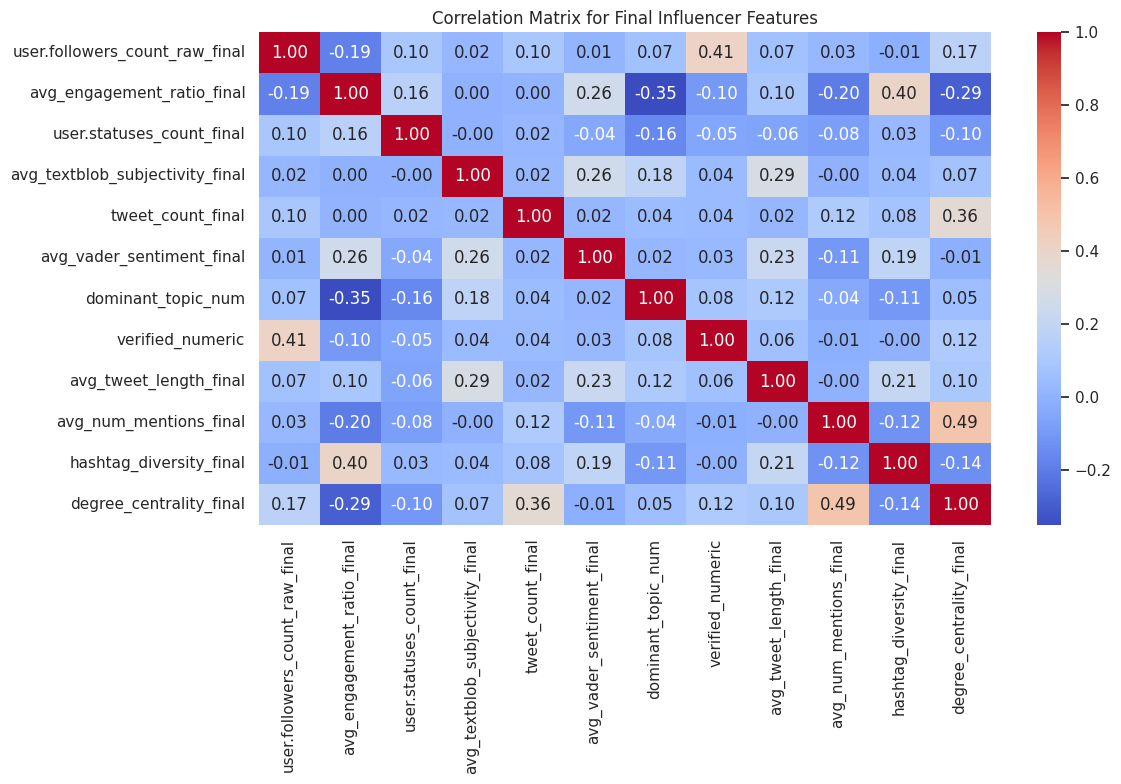

In [ ]:
# Correlation Analysis
print("\nPerforming correlation analysis")

# Using only the final (transformed) versions of the relevant features.
cluster_features = [
    'user.followers_count_raw_final',
    'avg_engagement_ratio_final',
    'user.statuses_count_final',
    'avg_textblob_subjectivity_final',
    'tweet_count_final',
    'avg_vader_sentiment_final',
    'dominant_topic_num',
    'verified_numeric',
    'avg_tweet_length_final',
    'avg_num_mentions_final',
    'hashtag_diversity_final',
    'degree_centrality_final'
]

# Compute the correlation matrix.
corr_matrix = micro_df[cluster_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Final Influencer Features")
plt.tight_layout()
plt.show()


Performing PCA for dimensionality reduction analysis...
Cumulative Explained Variance by Principal Components:
PC1: 0.18
PC2: 0.33
PC3: 0.44
PC4: 0.55
PC5: 0.63
PC6: 0.71
PC7: 0.78
PC8: 0.83
PC9: 0.88
PC10: 0.93
PC11: 0.97
PC12: 1.00


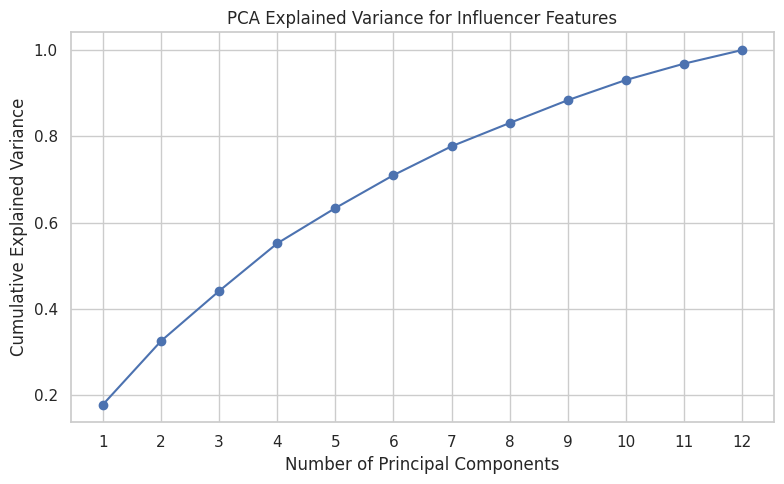

In [ ]:
# PCA for Dimensionality Reduction on micro-influencers

selected_features = [
    'user.followers_count_raw_final',
    'avg_engagement_ratio_final',
    'user.statuses_count_final',
    'avg_textblob_subjectivity_final',
    'tweet_count_final',
    'avg_vader_sentiment_final',
    'dominant_topic_num',
    'verified_numeric',
    'avg_tweet_length_final',
    'avg_num_mentions_final',
    'hashtag_diversity_final',
    'degree_centrality_final'
]

# PCA for Dimensionality Reduction
print("\nPerforming PCA for dimensionality reduction analysis...")
X_features = micro_df[selected_features].dropna()
scaler_features = StandardScaler()
X_features_scaled = scaler_features.fit_transform(X_features)

pca_model = PCA(n_components=len(selected_features))
pca_model.fit(X_features_scaled)
cumulative_variance = np.cumsum(pca_model.explained_variance_ratio_)
print("Cumulative Explained Variance by Principal Components:")
for i, var in enumerate(cumulative_variance, start=1):
    print(f"PC{i}: {var:.2f}")

plt.figure(figsize=(8,5))
plt.plot(range(1, len(selected_features)+1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance for Influencer Features")
plt.xticks(range(1, len(selected_features)+1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Choose the number of components that capture the best clustering performance
num_components = 9
pca_reducer = PCA(n_components=num_components)
X_reduced = pca_reducer.fit_transform(X_features_scaled)
print(f"Using {num_components} principal components, which explain about {cumulative_variance[num_components-1]:.2f} of the variance.\n")

Using 9 principal components, which explain about 0.88 of the variance.



**14. Clustering and Micro-Influencer Identification**

Performing clustering on influencer data
Influencers before dropping NaNs: 6974
Influencers after dropping NaNs: 6974
Rows removed due to NaNs: 0

k = 2, SSE = 64370.52, Silhouette Score = 0.173
k = 3, SSE = 58126.05, Silhouette Score = 0.128
k = 4, SSE = 50686.74, Silhouette Score = 0.170
k = 5, SSE = 44798.46, Silhouette Score = 0.195
k = 6, SSE = 41828.91, Silhouette Score = 0.181
k = 7, SSE = 39797.68, Silhouette Score = 0.165
k = 8, SSE = 37779.22, Silhouette Score = 0.169
k = 9, SSE = 36645.72, Silhouette Score = 0.158
k = 10, SSE = 35486.07, Silhouette Score = 0.156


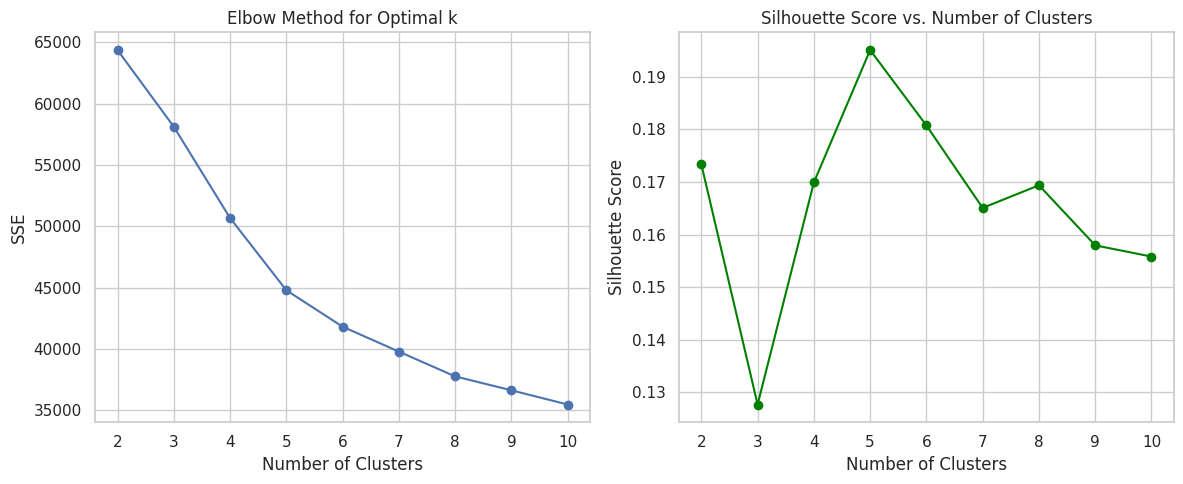

In [ ]:
# Clustering-Based Micro-Influencer Identification
print("Performing clustering on influencer data")

# Prepare data for clustering: drop NaNs using the selected clustering features
initial_count = micro_df.shape[0]
cluster_data = micro_df.dropna(subset=cluster_features).copy()
final_count = cluster_data.shape[0]
print(f"Influencers before dropping NaNs: {initial_count}")
print(f"Influencers after dropping NaNs: {final_count}")
print(f"Rows removed due to NaNs: {initial_count - final_count}\n")

# Scale the selected features for clustering and reduce dimensionality using PCA
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(cluster_data[cluster_features])
pca_reducer = PCA(n_components=num_components)
X_cluster_reduced = pca_reducer.fit_transform(X_cluster_scaled)

# Evaluate clustering quality using the elbow method and silhouette scores
sse = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_reduced)
    sse.append(kmeans.inertia_)
    sil = silhouette_score(X_cluster_reduced, kmeans.labels_)
    silhouette_scores.append(sil)
    print(f"k = {k}, SSE = {kmeans.inertia_:.2f}, Silhouette Score = {sil:.3f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(2,11), sse, marker='o', linestyle='-')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.xticks(range(2,11))

plt.subplot(1,2,2)
plt.plot(range(2,11), silhouette_scores, marker='o', color='green', linestyle='-')
plt.title("Silhouette Score vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(range(2,11))
plt.tight_layout()
plt.show()

In [ ]:
# Clustering & Top Micro-Influencer Selection (using composite_score)

# k value chosen with the max Silhouette Score and assign clusters on the micro-influencer PCA‐reduced data
optimal_k = 5
kmeans_opt = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_opt.fit_predict(X_cluster_reduced)

# Assign cluster labels back to micro_df
micro_df = micro_df.reset_index(drop=True)
micro_df['cluster'] = cluster_labels

# List Clusters and Identify Top Micro-Influencer for Each Brand
print("\nListing clusters and ranking micro-influencers using composite_score")

brands = micro_df['brand'].unique()
final_candidates = []  # To store the overall top candidate per brand

# Columns to display: raw + composite_score
combined_columns = [
    'user.id',
    'user.screen_name',
    'cluster',
    'user.followers_count_raw',
    'tweet_count',
    'composite_score',
    'avg_engagement_ratio',
    'avg_vader_sentiment',
    'degree_centrality',
    'dominant_topic_num',
    'verified_numeric'
]

for brand in brands:
    print(f"\n================= Brand: {brand} =================")
    bd = micro_df[micro_df['brand'] == brand].copy()

    # Ensure no missing clusters
    bd = bd.dropna(subset=['cluster'])

    # First 5 rows of cluster assignments
    print("\nCluster assignments (first 5 rows):")
    print(tabulate(bd[combined_columns].head(5), headers="keys", tablefmt="pretty"))

    # Within each cluster, pick the user with the highest composite_score
    idx = bd.groupby('cluster')['composite_score'].idxmax()
    best_per_cluster = bd.loc[idx]
    print("\nBest candidate from each cluster:")
    print(tabulate(best_per_cluster[combined_columns], headers="keys", tablefmt="pretty"))

    # Then pick the overall top micro-influencer with respect to brand
    overall_best = best_per_cluster.loc[best_per_cluster['composite_score'].idxmax()]
    final_candidates.append(overall_best)
    print("\nOverall top micro-influencer for", brand, ":")
    print(tabulate(pd.DataFrame([overall_best]), headers="keys", tablefmt="pretty"))


Listing clusters and ranking micro-influencers using composite_score

================= Brand: Adidas =================

Cluster assignments (first 5 rows):
+---+---------+------------------+---------+--------------------------+-------------+---------------------+------------------------+---------------------+------------------------+--------------------+------------------+
|   | user.id | user.screen_name | cluster | user.followers_count_raw | tweet_count |   composite_score   |  avg_engagement_ratio  | avg_vader_sentiment |   degree_centrality    | dominant_topic_num | verified_numeric |
+---+---------+------------------+---------+--------------------------+-------------+---------------------+------------------------+---------------------+------------------------+--------------------+------------------+
| 0 |  1075   |     narendra     |    4    |          23110           |      1      | 0.3749214501672984  | 0.00025962786672436173 |       0.0258        | 8.002133902373966e-05  |   

In [ ]:
# Per-Cluster Max Influence Score by Brand

print("\nPer-Cluster Max Composite Score by Brand\n")

for brand in micro_df['brand'].unique():
    bd = micro_df[micro_df['brand'] == brand]
    # max composite_score per cluster
    cluster_best = (
        bd
        .groupby('cluster', as_index=False)['composite_score']
        .max()
        .sort_values('cluster')
    )
    fig = px.bar(
        cluster_best,
        x='cluster',
        y='composite_score',
        title=f"Max Composite Score per Cluster — {brand}",
        labels={'cluster':'Cluster', 'composite_score':'Max Composite Score'},
        color='cluster',
        color_continuous_scale='Viridis',
        template='plotly_white'
    )
    fig.update_layout(
        bargap=0.25,
        height=450,
        width=800,
        xaxis=dict(title='Cluster', dtick=1),
        yaxis=dict(title='Max Composite Score'),
        title=dict(x=0.5, font=dict(size=18)),
        font=dict(size=13)
    )
    fig.show()


# Overall Top Candidate Composite Score by Brand
print("\nOverall Top Micro-Influencer Composite Score by Brand\n")

overall_df = pd.DataFrame(final_candidates)
fig = px.bar(
    overall_df,
    x='brand',
    y='composite_score',
    title="Overall Top Micro-Influencer Composite Score by Brand",
    labels={'brand':'Brand', 'composite_score':'Composite Score'},
    color='brand',
    color_discrete_sequence=px.colors.qualitative.Plotly,
    template='plotly_white'
)
fig.update_layout(
    bargap=0.3,
    height=400,
    width=700,
    title=dict(x=0.5, font=dict(size=18)),
    font=dict(size=13)
)
fig.show()


Per-Cluster Max Composite Score by Brand




Overall Top Micro-Influencer Composite Score by Brand




2D PCA Projection of Clusters with Top Candidates Annotated



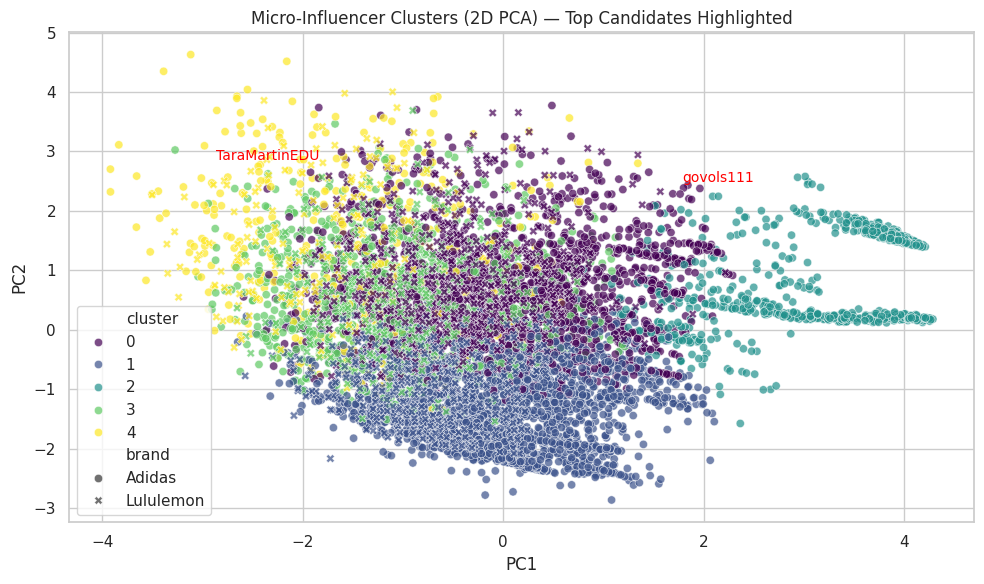

In [ ]:
# 2D Visualization of Clusters using PCA with Annotations
print("\n2D PCA Projection of Clusters with Top Candidates Annotated\n")

# 2-component projection of the same X_cluster_reduced
from sklearn.decomposition import PCA
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_cluster_reduced)

# attach PC1/PC2 back onto micro_df
micro_df['PC1'], micro_df['PC2'] = X_vis[:, 0], X_vis[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=micro_df,
    x='PC1', y='PC2',
    hue='cluster', style='brand',
    palette='viridis', alpha=0.7
)
# annotate each brand’s overall best
for cand in final_candidates:
    row = micro_df[micro_df['user.id'] == cand['user.id']].iloc[0]
    plt.annotate(
        row['user.screen_name'],
        (row['PC1'], row['PC2']),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=10,
        color='red'
    )
plt.title("Micro-Influencer Clusters (2D PCA) — Top Candidates Highlighted")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

**15. Final Overview**

In [ ]:
# Convert final_candidates list to DataFrame
df_final = pd.DataFrame(final_candidates)

# Key columns
summary = df_final[[
    'user.screen_name',
    'brand',
    'user.followers_count_raw',
    'avg_engagement_ratio',
    'avg_vader_sentiment',
    'degree_centrality',
    'composite_score',
    'cluster'
]].copy()

# Format numeric columns for readability
summary['user.followers_count_raw'] = summary['user.followers_count_raw'].astype(int)
for col in ['avg_engagement_ratio', 'avg_vader_sentiment', 'degree_centrality', 'composite_score']:
    summary[col] = summary[col].round(4)

# Interactive Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(summary.columns),
        fill_color='darkslategray',
        font=dict(color='white', size=14),
        align='left'
    ),
    cells=dict(
        values=[summary[col] for col in summary.columns],
        fill_color='lightgray',
        font=dict(color='black', size=12),
        align='left'
    )
)])
fig.update_layout(
    title_text="Final Top Micro-Influencer Candidates",
    title_x=0.5,
    margin=dict(t=50, b=10)
)
fig.show()

In [ ]:
# Exporting Final Data and Summary Statistics

# Export the final aggregated influencer data to CSV.
print("\nExporting micro-influencer data")
micro_df.to_csv("micro_influencers_final.csv", index=False)
print("Done: ‘micro_influencers_final.csv’ contains the filtered, scored & clustered candidates.")


Exporting micro-influencer data
Done: ‘micro_influencers_final.csv’ contains the filtered, scored & clustered candidates.
